# Estimated Storm Motion Vector Calculation

This script finds the estimated storm motion using subsetted reflectivity data around a point of interest. It is the method used in McDonald and Weiss (2021) and adopted in Ostaszewski et al. 2024, which is based on the method described in Shabbott and Markowski (2006)


In [1]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pyart;
import math
from functions_radar import get_radar_from_aws
import pandas as pd

def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array-value)).argmin()


plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', titlesize=22, labelsize=15)

# HD baybeeeeee
%config InlineBackend.figure_format='retina'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p14 = _nlv < LooseVersion("1.14")
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p15 = _nlv < LooseVersion("1.15")
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p16 = _nlv < LooseVersion("1.16")
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__

In [2]:
### functions

def get_radar_subset(radar, xsn, ysn, station, box_radius=30):
    
    ''' Get a reflectivity subset around a given radar-relative location. 
    
    INPUTS
    radar:      radar object 
    xsn:        radar-relative sticknet position in meters
    ysn:        radar-relative sticknet poisition in meters
    station:    radar site ID
    box_radius: size of initial subset (square with side length box_radius*2)
    
    OUTPUT: x grid (2D, meters), y grid (2D, meters), reflectivity (2D)'''
    
    # grid the data
    # 1 km resolution... see the pyart docs to change this 
    # radars are indexed to form a box over the 2016/2017 Stesonet domain
    
    #IOP2
#     if station == 'KLZK':
#         grid = pyart.map.grid_from_radars(radar,(10,210,230), ((0,10000), (-160000 ,50000), (20000,210000)))


    #IOP4
#     if station == 'KHTX':
#         grid = pyart.map.grid_from_radars(radar, (10,190,250), ((0,10000), (-100000,90000), (-210000,-40000)))


#     #IOP5
    if station == 'KNQA':
        grid = pyart.map.grid_from_radars(radar, (10,190,220), ((0,10000), (-50000,140000), (-160000,60000)))
        
    
    x, y = grid.x['data'], grid.y['data']
    box = box_radius # 30 => 60 km length box

    sn_x = find_nearest(xsn, grid.x['data'])
    sn_y = find_nearest(ysn, grid.y['data'])

    x_subset = x[sn_x-box:sn_x+box]
    y_subset = y[sn_y-box:sn_y+box]
    ref_subset = grid.fields['reflectivity']['data'][0,sn_y-box:sn_y+box, sn_x-box:sn_x+box]
    
    return x_subset, y_subset, ref_subset

def get_radar_loc(station):
    ''' get the lat and lon location of each radar.
    This data is available in the radar object metadata. '''
    
    if station == 'KLZK':
        radar_lat, radar_lon = 34.8364, -92.2622
    if station == 'KHTX':
        radar_lat, radar_lon = 34.9306, -86.0833
    if station == 'KNQA':
        radar_lat, radar_lon = 35.3447, -89.8733
        
    return radar_lat, radar_lon  

def get_dxdy(lat1, lon1, lat2, lon2):
    '''Finds the distance in meters between two lat/lon points '''
    
    dx = (lon1-lon2)*40000*math.cos((lat1+lat2)*math.pi/360)/360
    dy = (lat1-lat2)*40000/360
    return dx*1000, dy*1000 # meters


def min_mse_solidgrid(ref1, ref2, dtime, boxr=20):
    
    '''loops over shifts in the x and y direction and finds which shift results in a 
       minimization of mean square error between ref1 and ref2. 
       The shift and change in time is used to determine estimated storm motion.
       
       returns the xshift, yshift, estimated storm U, estimated storm V. U and V are in m/s'''
    
    xvals, yvals, MSEs = [],[],[]
    ### shapes of grids are (y, x)
    new_r2 = ref2[boxr:-boxr, boxr:-boxr] 

    # limit the movement to the box radius
    for xmove in np.arange(1,boxr):
        for ymove in np.arange(-boxr+1,boxr):
            if ymove > 0:
                new_r1 = ref1[(boxr-ymove):(-boxr-ymove), (boxr-xmove):(-boxr-xmove)]
                mses = ((new_r1-new_r2)**2).mean()
                xvals.append(xmove)
                yvals.append(ymove)
                MSEs.append(mses)
            if ymove < 0:
                new_r1 = ref1[(boxr+abs(ymove)):(-boxr+abs(ymove)), (boxr-xmove):(-boxr-xmove)] 
                mses = ((new_r1-new_r2)**2).mean()
                xvals.append(xmove)
                yvals.append(ymove)
                MSEs.append(mses)

    MSEs = np.asarray(MSEs)
    best = np.where(MSEs == np.min(MSEs))[0][0]
    U = xvals[best]*1000 / dtime
    V = yvals[best]*1000 / dtime  

    print(f'minimum MSE ({np.min(MSEs)}), gives\nU: {np.round(U,1)} m/s and V: {np.round(V,1)} m/s')
    return xvals[best], yvals[best], np.round(U,1), np.round(V,1)

In [3]:
SNSfile = 'E:\\PERiLS_Y2\\Excel_SN\\Before_CPA\\PERiLS_IOP5Y2_thermo.xlsx'
sns = pd.read_excel(SNSfile)
sns = sns[sns['TOA_coldpool_final'].notna()]

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\_optional.py:99: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(version) < minimum_version:
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\xlrd\xlsx.py:39: DeprecationWarning: defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.
  try: import defusedxml.cElementTree as ET
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

In [4]:
sns

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

IOP       date    ID      lat      lon array_type        mode  MC_rel_toa  \
0     5 2023-04-05  101A  35.2718 -90.5465     Coarse      Hybrid         NaN   
1     5 2023-04-05  102A  35.2649 -90.7921     Coarse      Hybrid         NaN   
2     5 2023-04-05  103A  35.4967 -90.7399     Coarse  Mesovortex         NaN   
3     5 2023-04-05  104A  35.5378 -90.7225       Fine  Mesovortex         NaN   
4     5 2023-04-05  105A  35.4820 -91.2120     Coarse  Mesovortex         NaN   
5     5 2023-04-05  106A  35.8379 -91.1627     Coarse  Mesovortex         NaN   
6     5 2023-04-05  107A  36.1318 -90.9296     Coarse  Mesovortex         NaN   
7     5 2023-04-05  108A  35.5529 -90.7217       Fine  Mesovortex         NaN   
8     5 2023-04-05  109A  35.6897 -90.7936     Coarse  Mesovortex         NaN   
9     5 2023-04-05  110A  35.2503 -91.0640     Coarse      Hybrid         NaN   
10    5 2023-04-05  111A  35.5225 -90.7260       Fine  Mesovortex         NaN   
11    5 2023-04-05  112A  35.5705 -90.7246       Fine  Mesovortex         NaN   
12    5 2023-04-05  213A  36.0637 -90.5088     Coarse  Mesovortex         NaN   
13    5 2023-04-05  214A  35.7558 -90.3207     Coarse  Mesovortex         NaN   
14    5 2023-04-05  215A  35.6348 -90.7171       Fine  Mesovortex         NaN   
15    5 2023-04-05  216A  35.8755 -90.0886     Coarse  Mesovortex         NaN   
16    5 2023-04-05  217A  36.1298 -90.1778     Coarse  Mesovortex         NaN   
17    5 2023-04-05  218A  35.6185 -90.7224       Fine  Mesovortex         NaN   
18    5 2023-04-05  219A  36.0461 -90.6661     Coarse  Mesovortex         NaN   
19    5 2023-04-05  220A  35.5874 -90.7228       Fine  Mesovortex         NaN   
20    5 2023-04-05  221A  35.2800 -90.2527     Coarse      Hybrid         NaN   
21    5 2023-04-05  222A  35.5339 -90.4012     Coarse  Mesovortex         NaN   
22    5 2023-04-05  223A  35.6160 -90.1069     Coarse  Mesovortex         NaN   
23    5 2023-04-05  224A  35.6024 -90.7224       Fine  Mesovortex         NaN   

   type tor  ... TOA_coldpool_final TOA_mods Threshold     U     V  ref_angle  \
0     R  NT  ...      4/5/2023 1734      NaN        -3  18.0  12.0      -12.1   
1     R  NT  ...      4/5/2023 1714      NaN        -3  15.2  18.2       -9.2   
2     R  NT  ...      4/5/2023 1704      NaN        -3  32.0  17.4      -44.5   
3     R  NT  ...      4/5/2023 1702      NaN        -3  23.3  14.5      -38.6   
4     R  NT  ...      4/5/2023 1627      NaN        -3  21.4   7.1      -22.0   
5     R  NT  ...      4/5/2023 1604      NaN        -3  17.9  14.3      -42.7   
6     R  NT  ...      4/5/2023 1610      NaN        -3  22.9  19.6      -30.3   
7     R  NT  ...      4/5/2023 1700      NaN        -3  23.3  14.5      -39.8   
8     R  NT  ...      4/5/2023 1644      NaN        -3  20.5   8.8      -17.1   
9     R  NT  ...      4/5/2023 1655      NaN        -3  15.1  21.1       -2.8   
10    R  NT  ...      4/5/2023 1703      NaN        -3  26.2  14.5      -42.5   
11    R  NT  ...      4/5/2023 1659      NaN        -3  20.3  11.6      -42.2   
12    R  NT  ...      4/5/2023 1647      NaN        -3  20.5   5.9      -23.6   
13    R  NT  ...      4/5/2023 1717      NaN        -3  25.7   5.7      -32.1   
14    R  NT  ...      4/5/2023 1654      NaN        -3  23.3  14.5      -39.6   
15    R  NT  ...      4/5/2023 1733      NaN        -3  32.9  21.0      -35.7   
16    R  NT  ...      4/5/2023 1710      NaN        -3  27.4  18.2      -44.6   
17    R  NT  ...      4/5/2023 1654      NaN        -3  23.3  14.5      -40.1   
18    R  NT  ...      4/5/2023 1636      NaN        -3  21.4   6.1       15.9   
19    R  NT  ...      4/5/2023 1658      NaN        -3  20.3  11.6      -40.5   
20    R  NT  ...      4/5/2023 1756      NaN        -3  19.0  10.8       10.2   
21    R  NT  ...      4/5/2023 1729      NaN        -3  13.6   5.4      -54.1   
22    R  NT  ...      4/5/2023 1741      NaN        -3  38.0  20.5      -49.0   
23    R  NT  ...      4/5/2023 165

In [28]:
TOA50 = pd.to_datetime('2023-04-05 16:54:00')

Getting Radar Subset for 103A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (13.740911483764648), gives
U: 15.1 m/s and V: 18.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

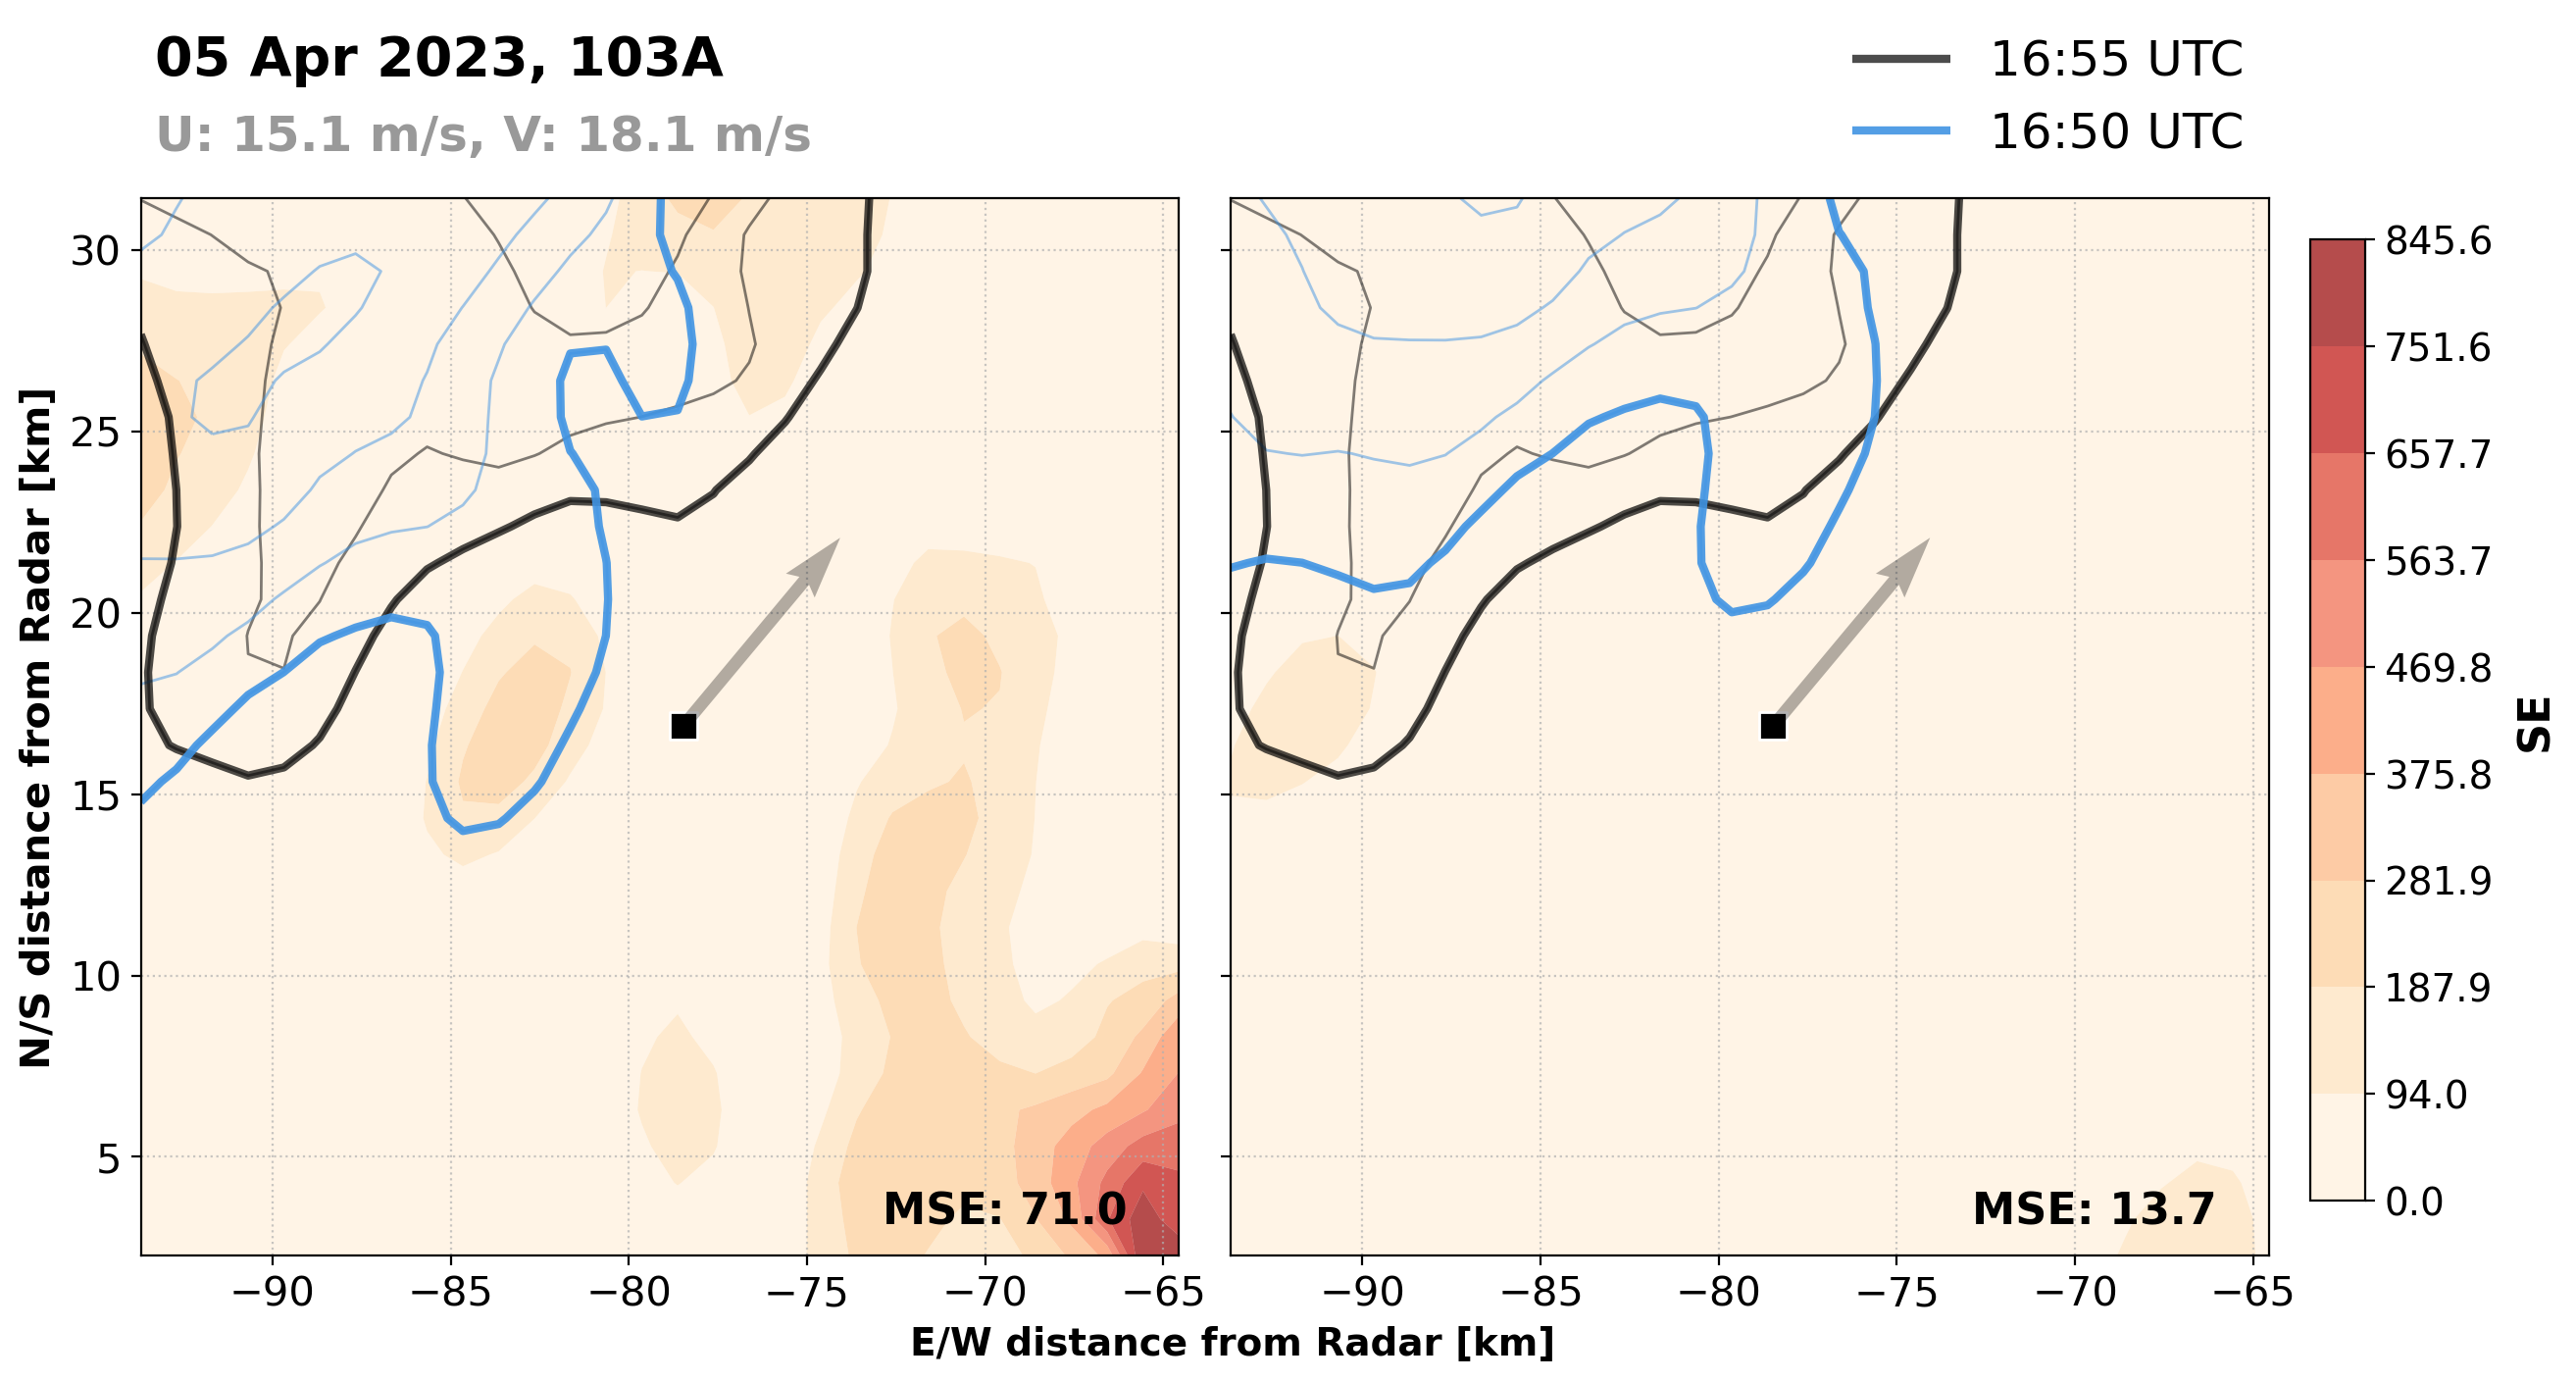

Getting Radar Subset for 104A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (14.075981140136719), gives
U: 15.1 m/s and V: 18.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

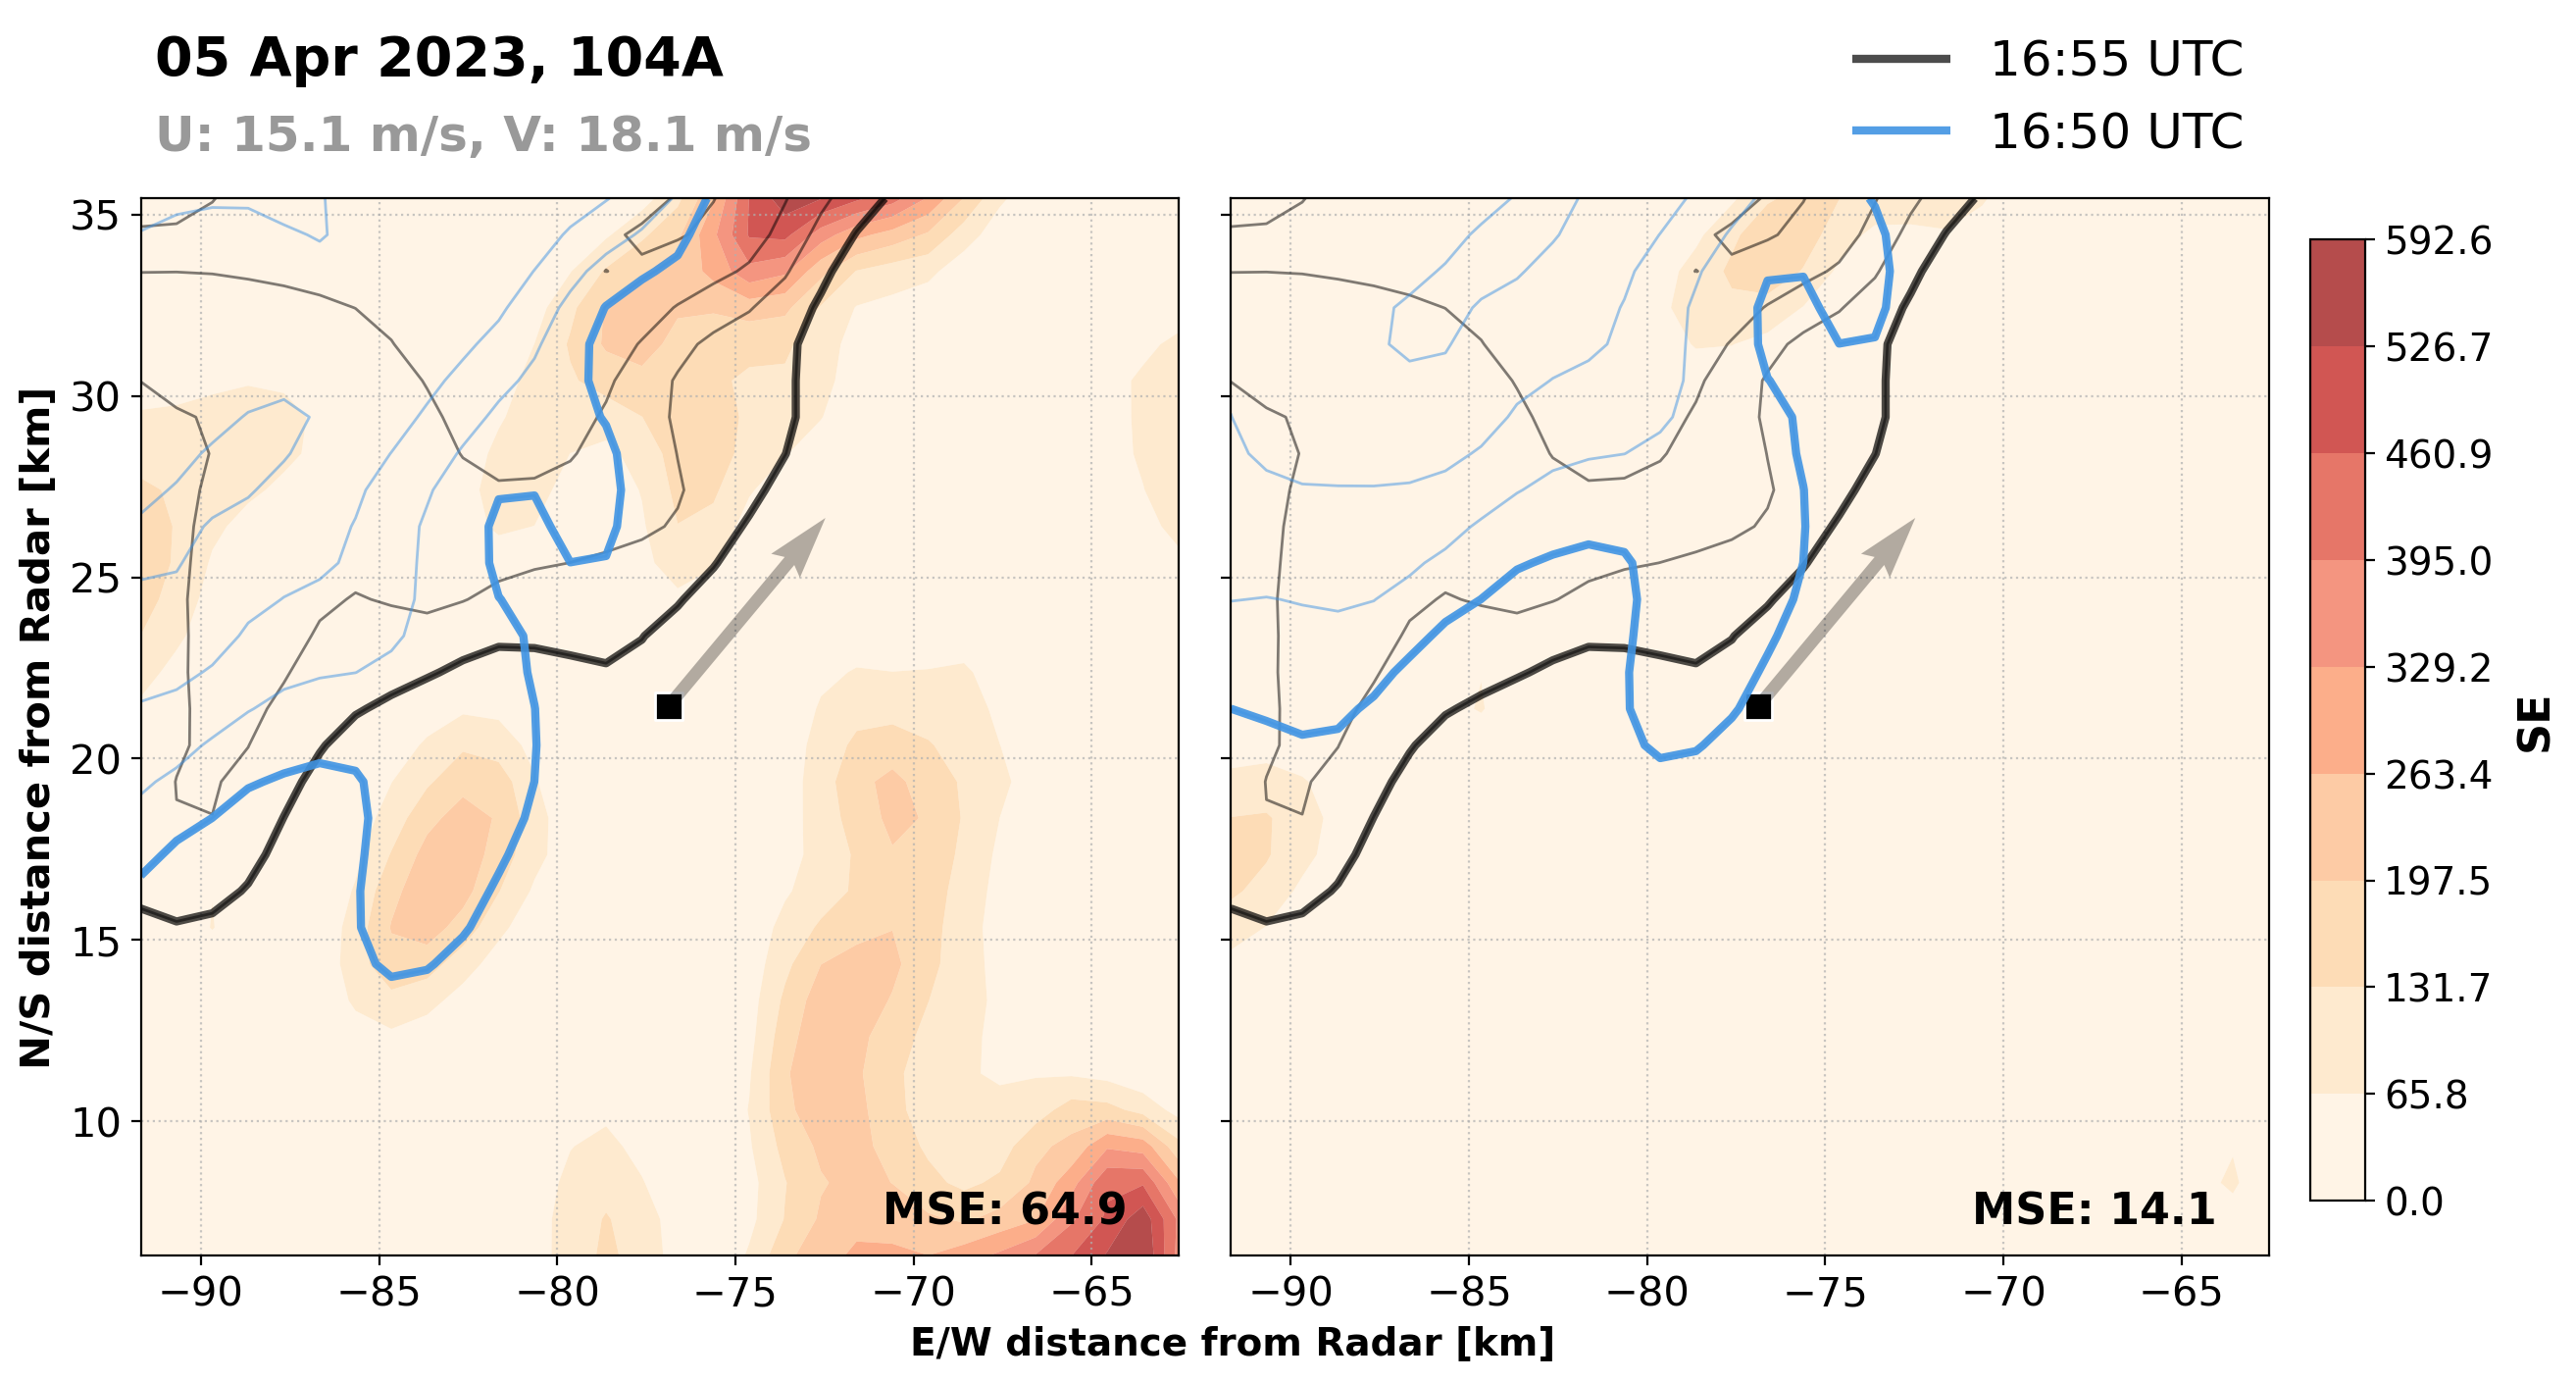

Getting Radar Subset for 108A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (16.820676803588867), gives
U: 15.1 m/s and V: 18.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

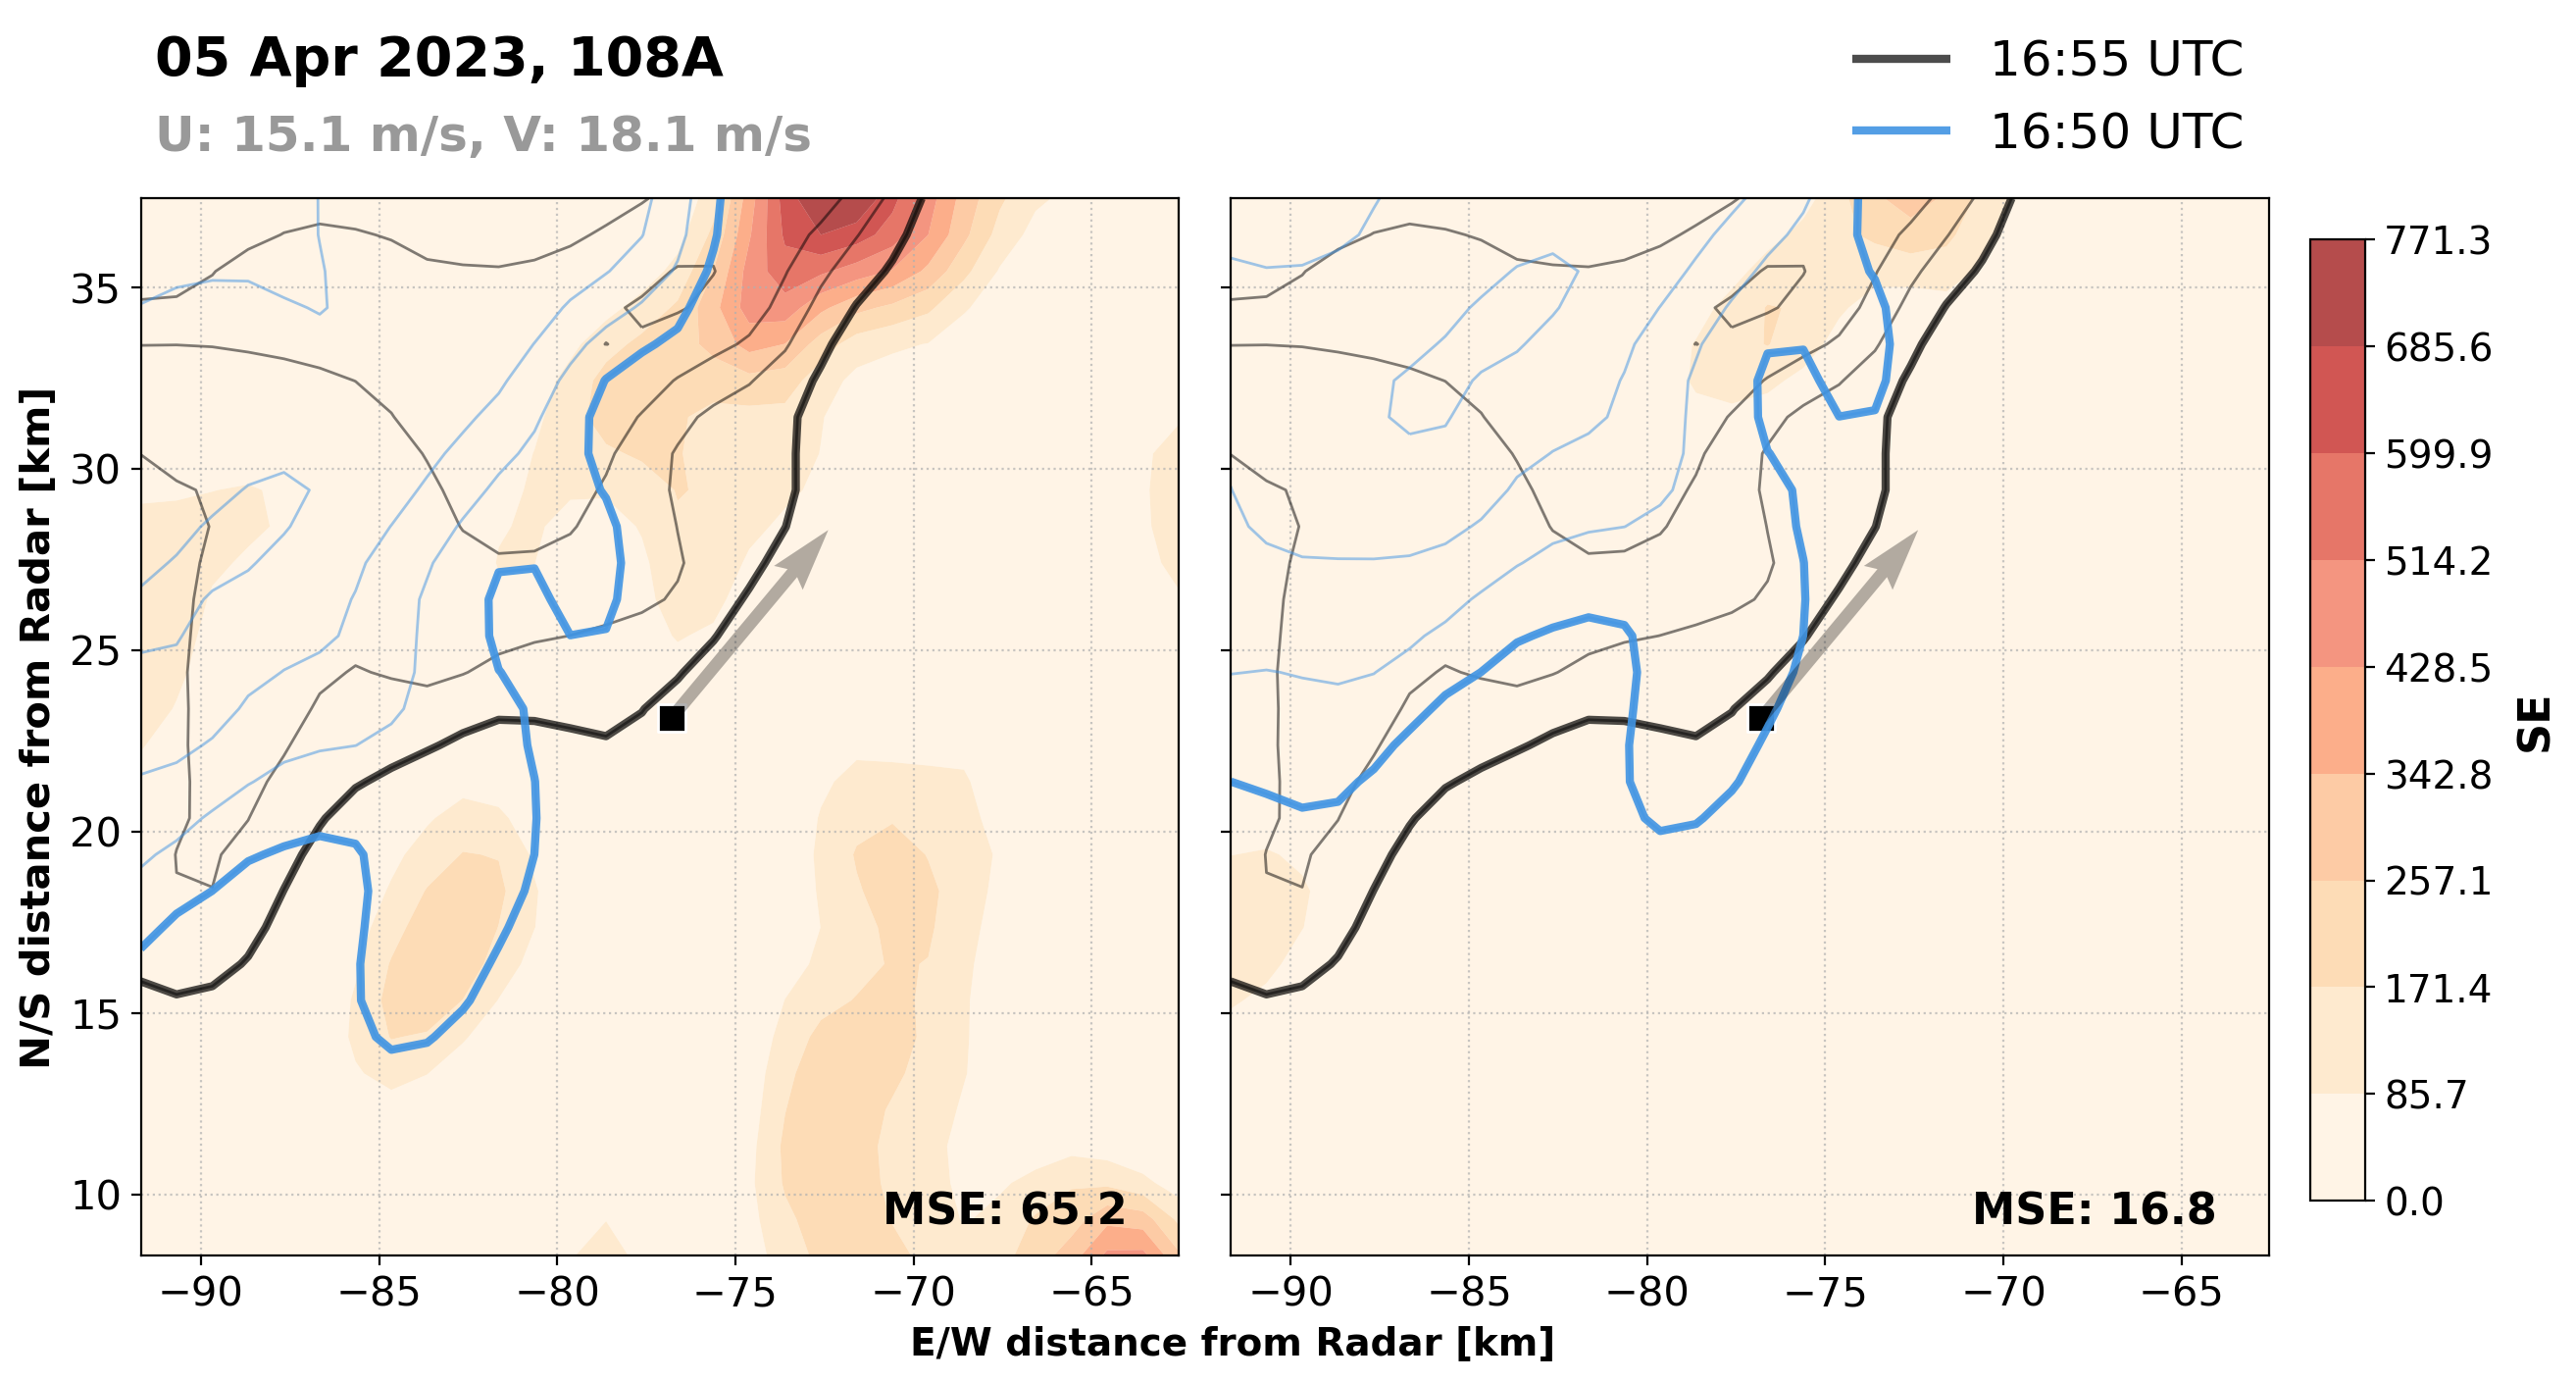

Getting Radar Subset for 109A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (13.670598983764648), gives
U: 21.1 m/s and V: 18.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

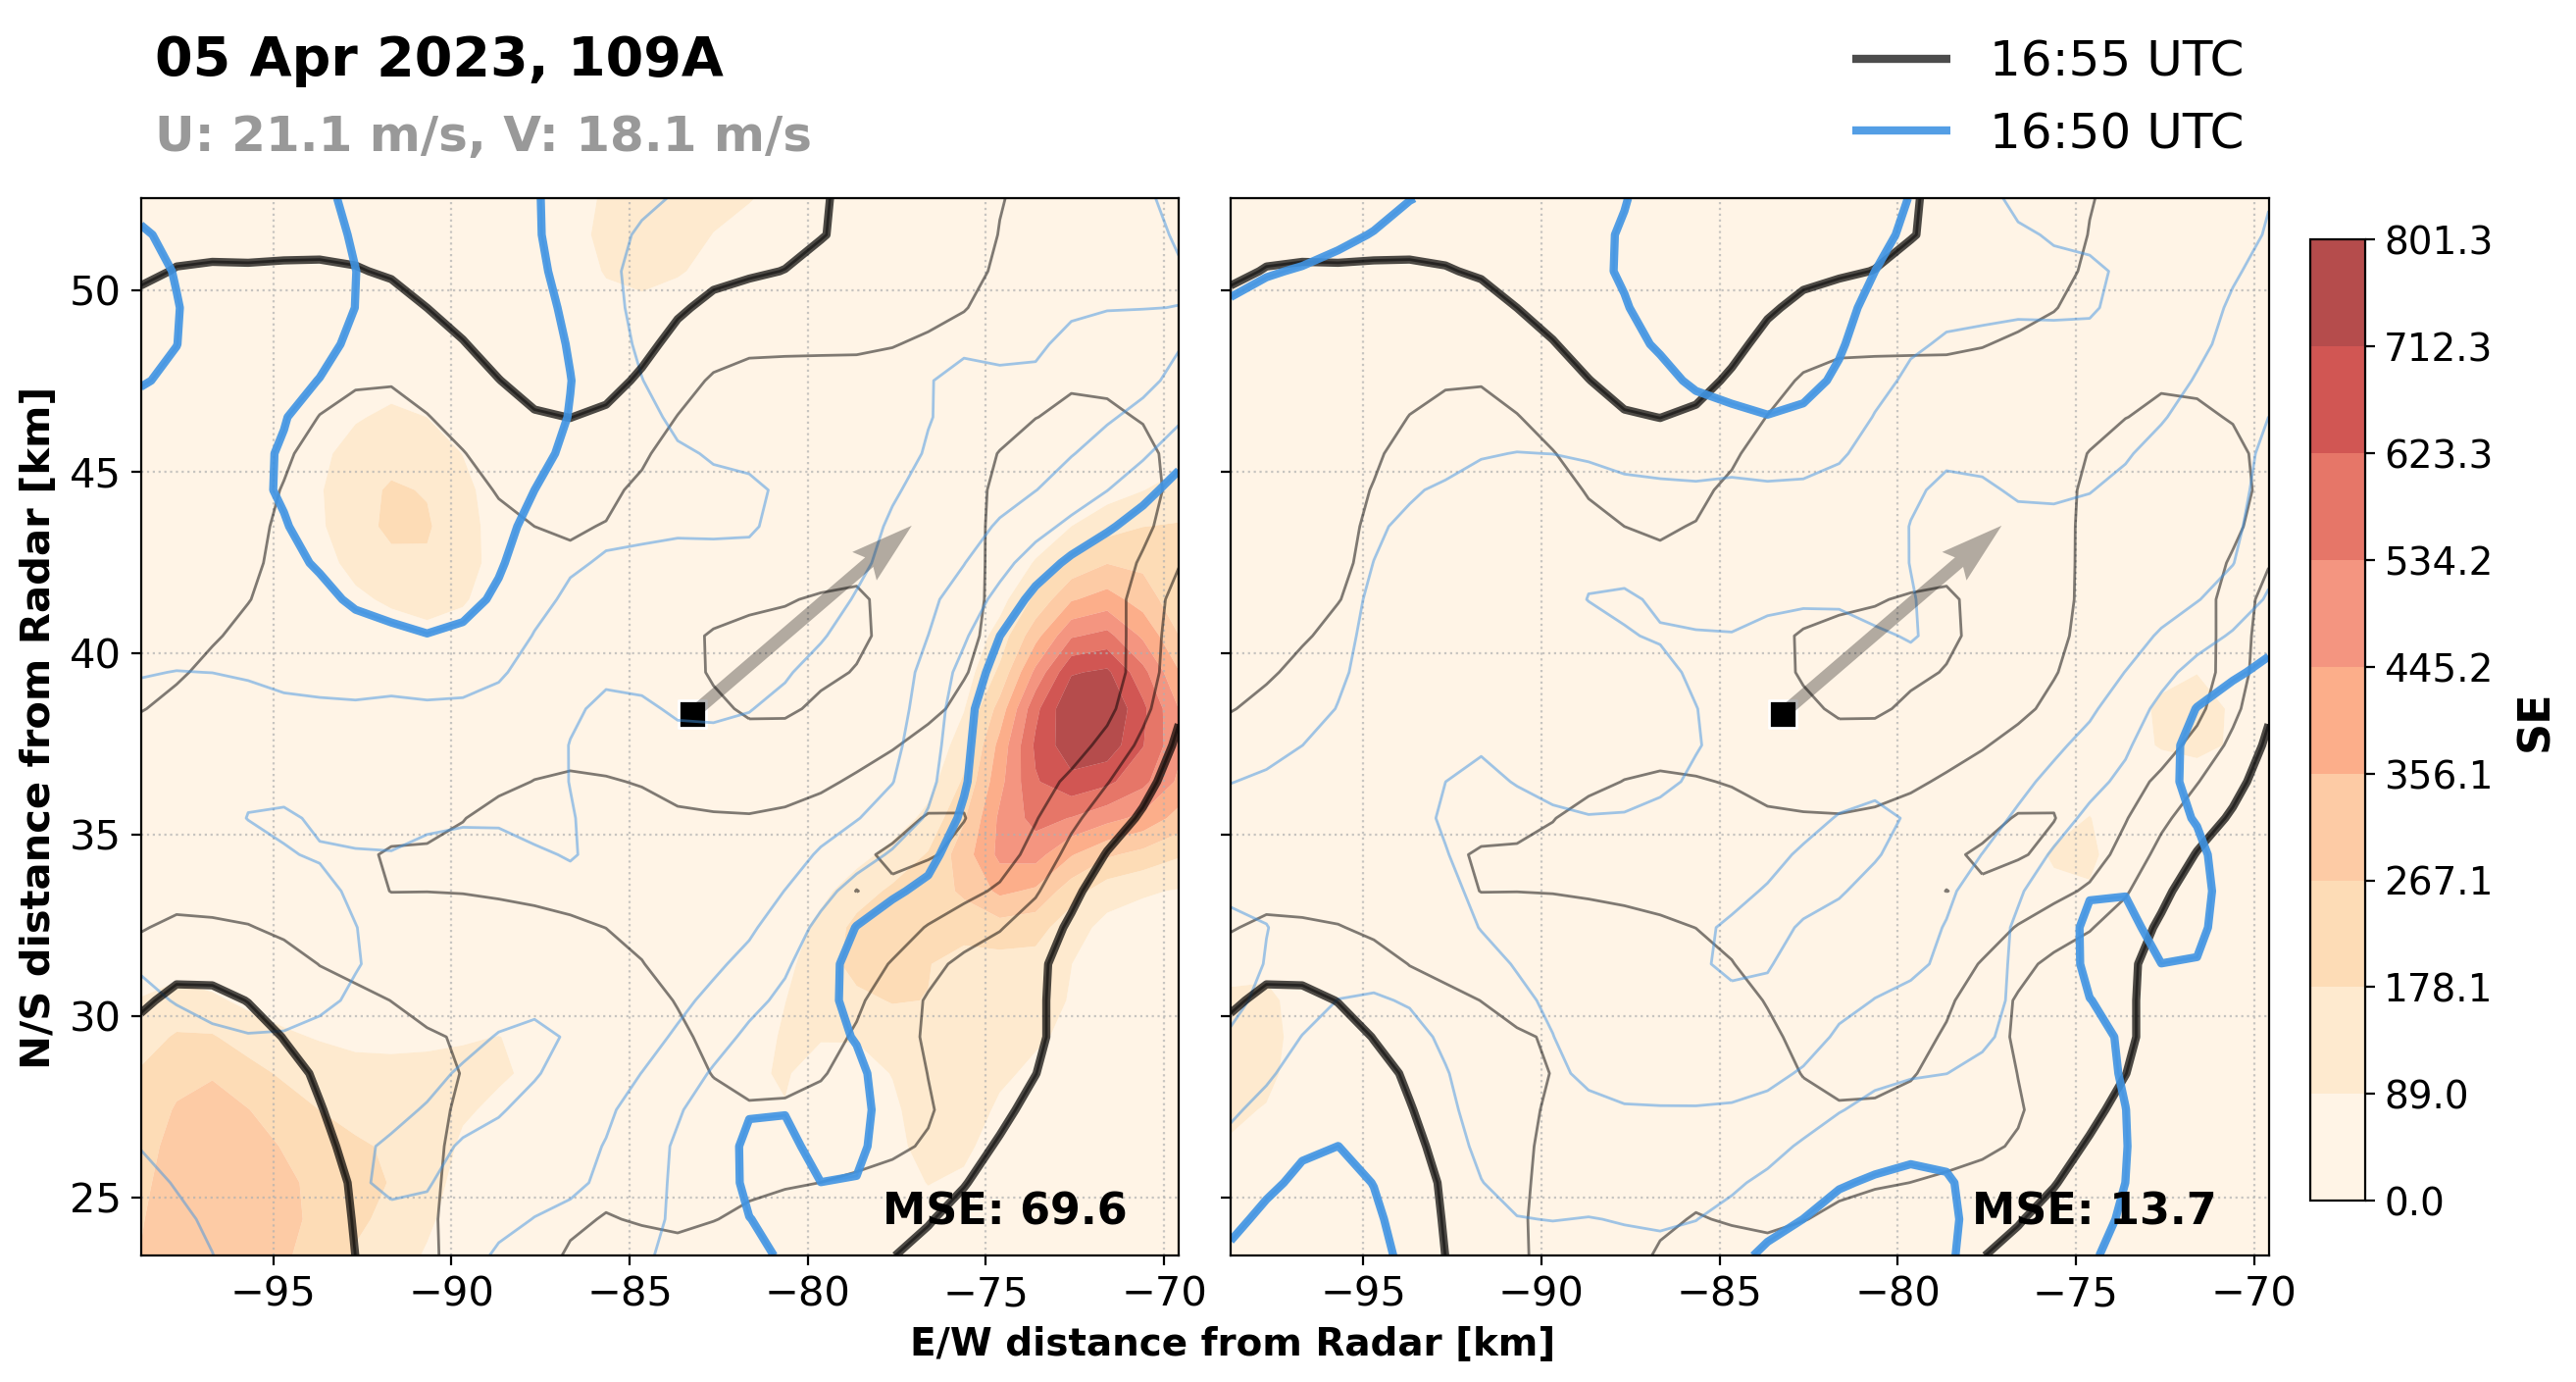

Getting Radar Subset for 111A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (13.405618667602539), gives
U: 15.1 m/s and V: 18.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

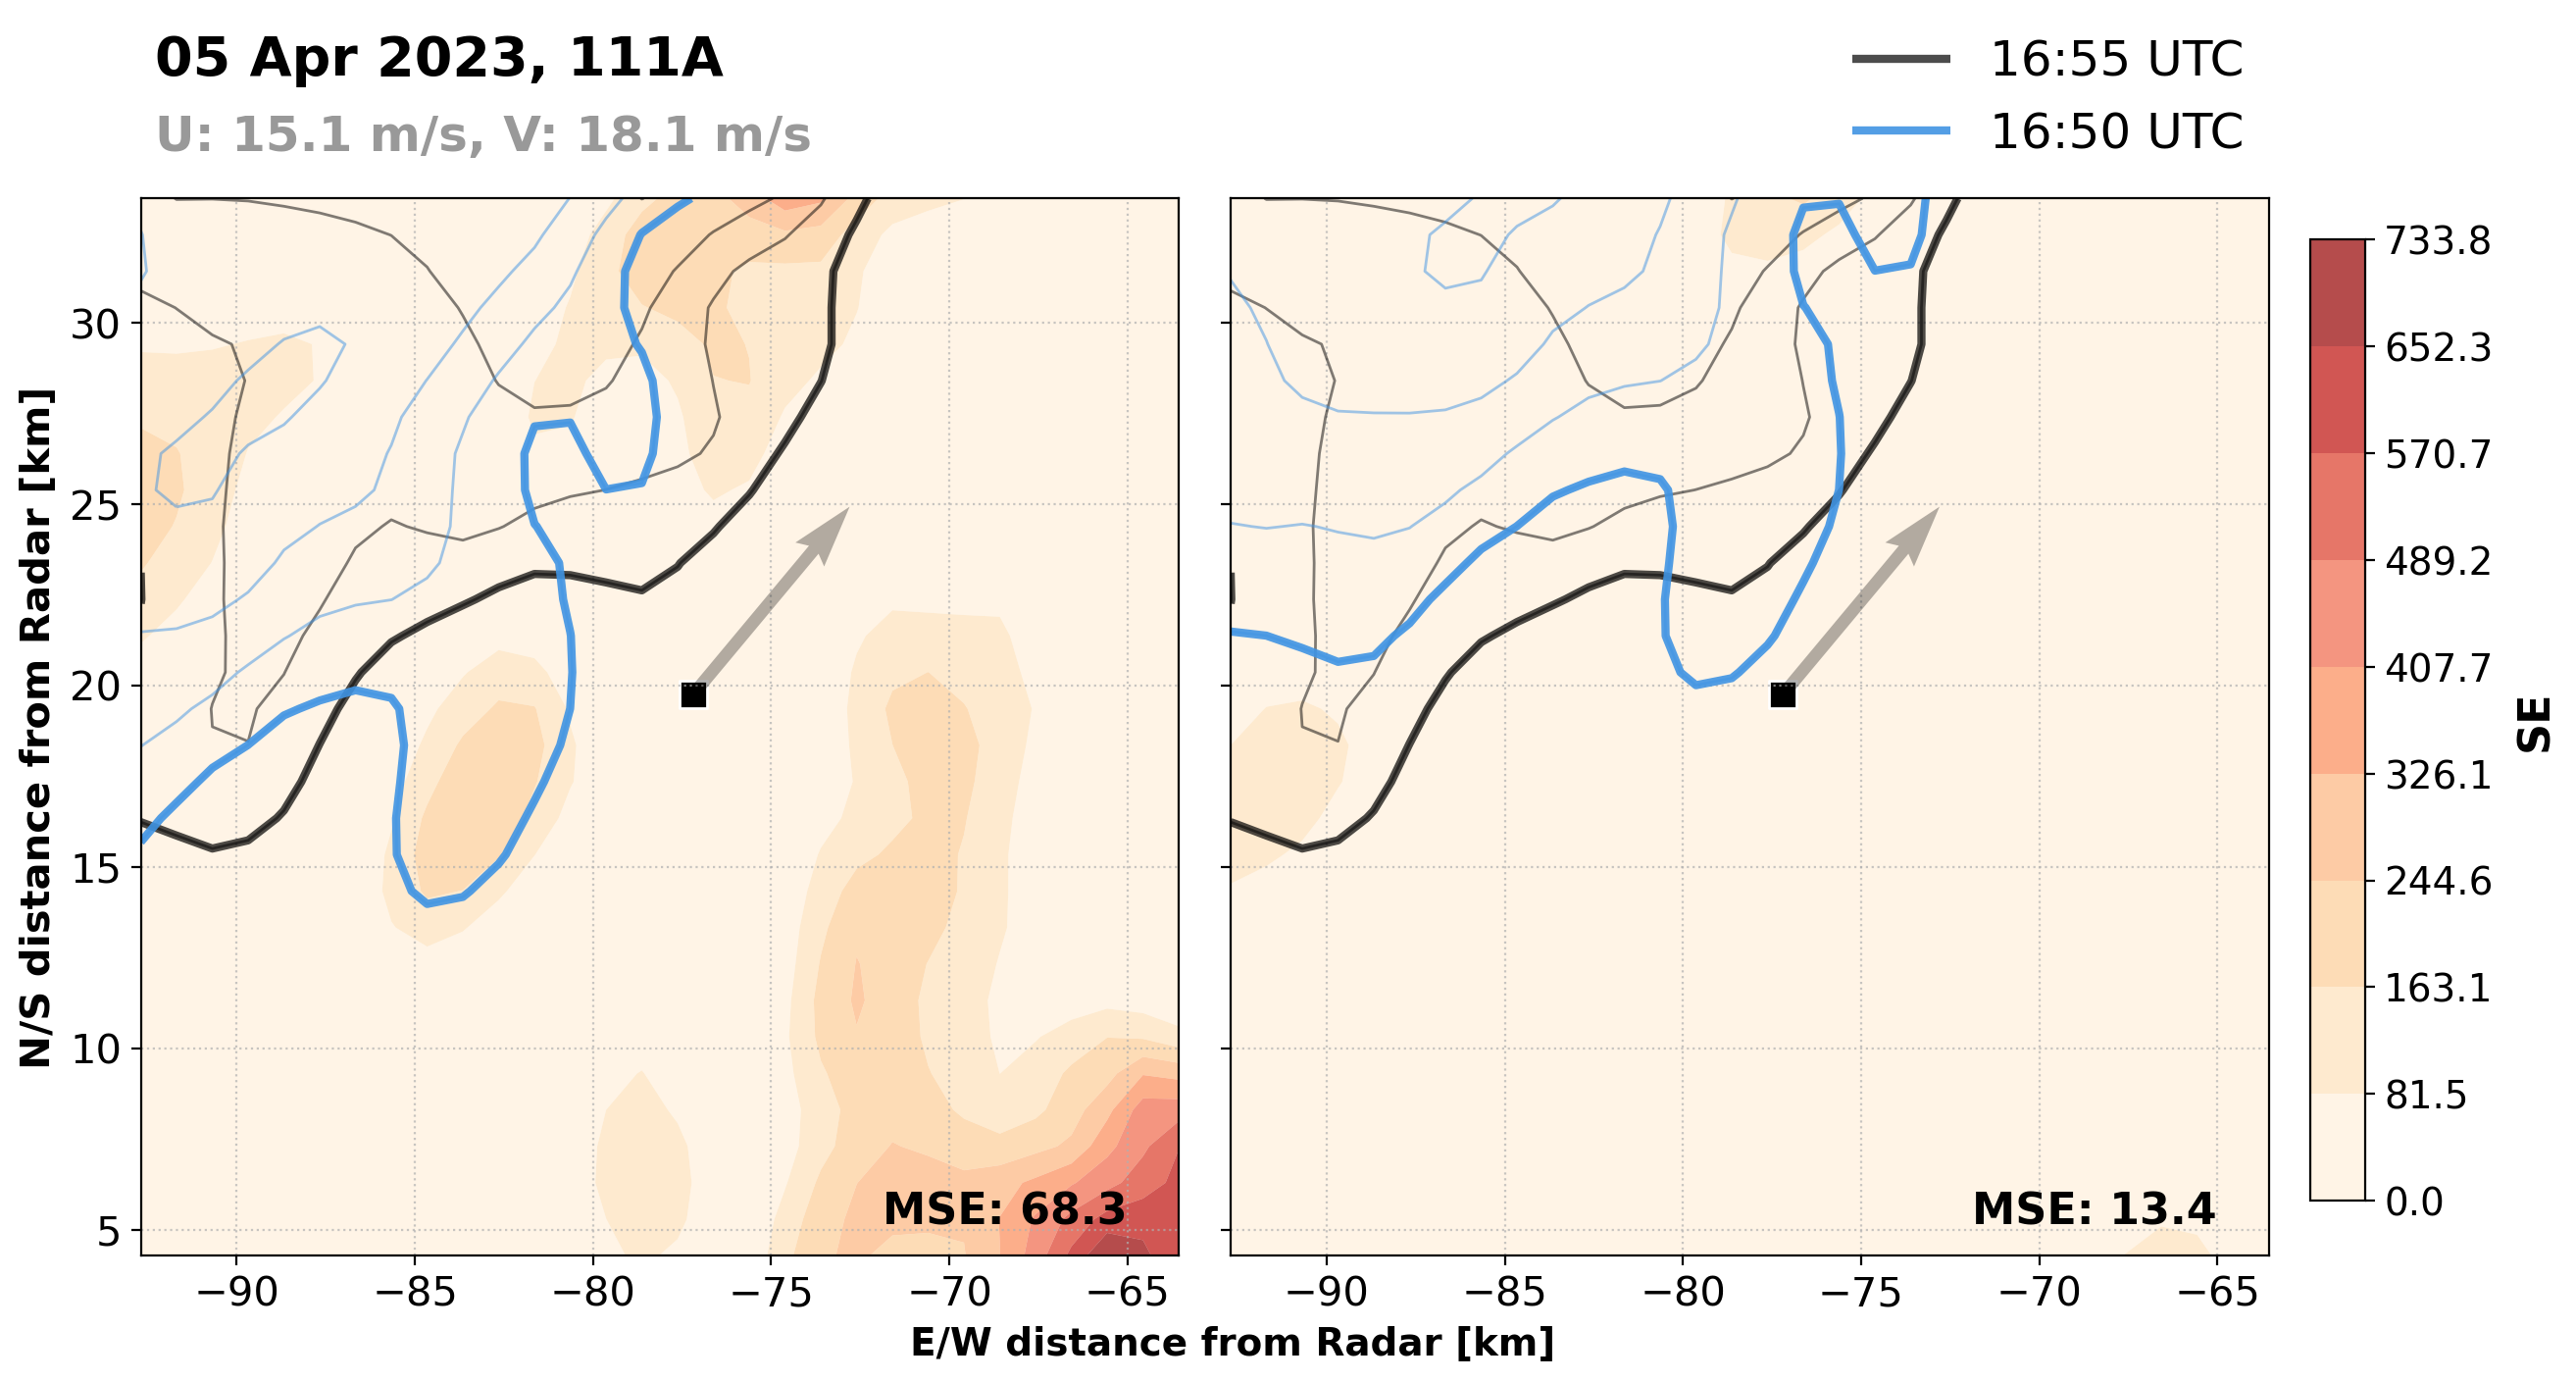

Getting Radar Subset for 112A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (18.2706298828125), gives
U: 15.1 m/s and V: 15.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

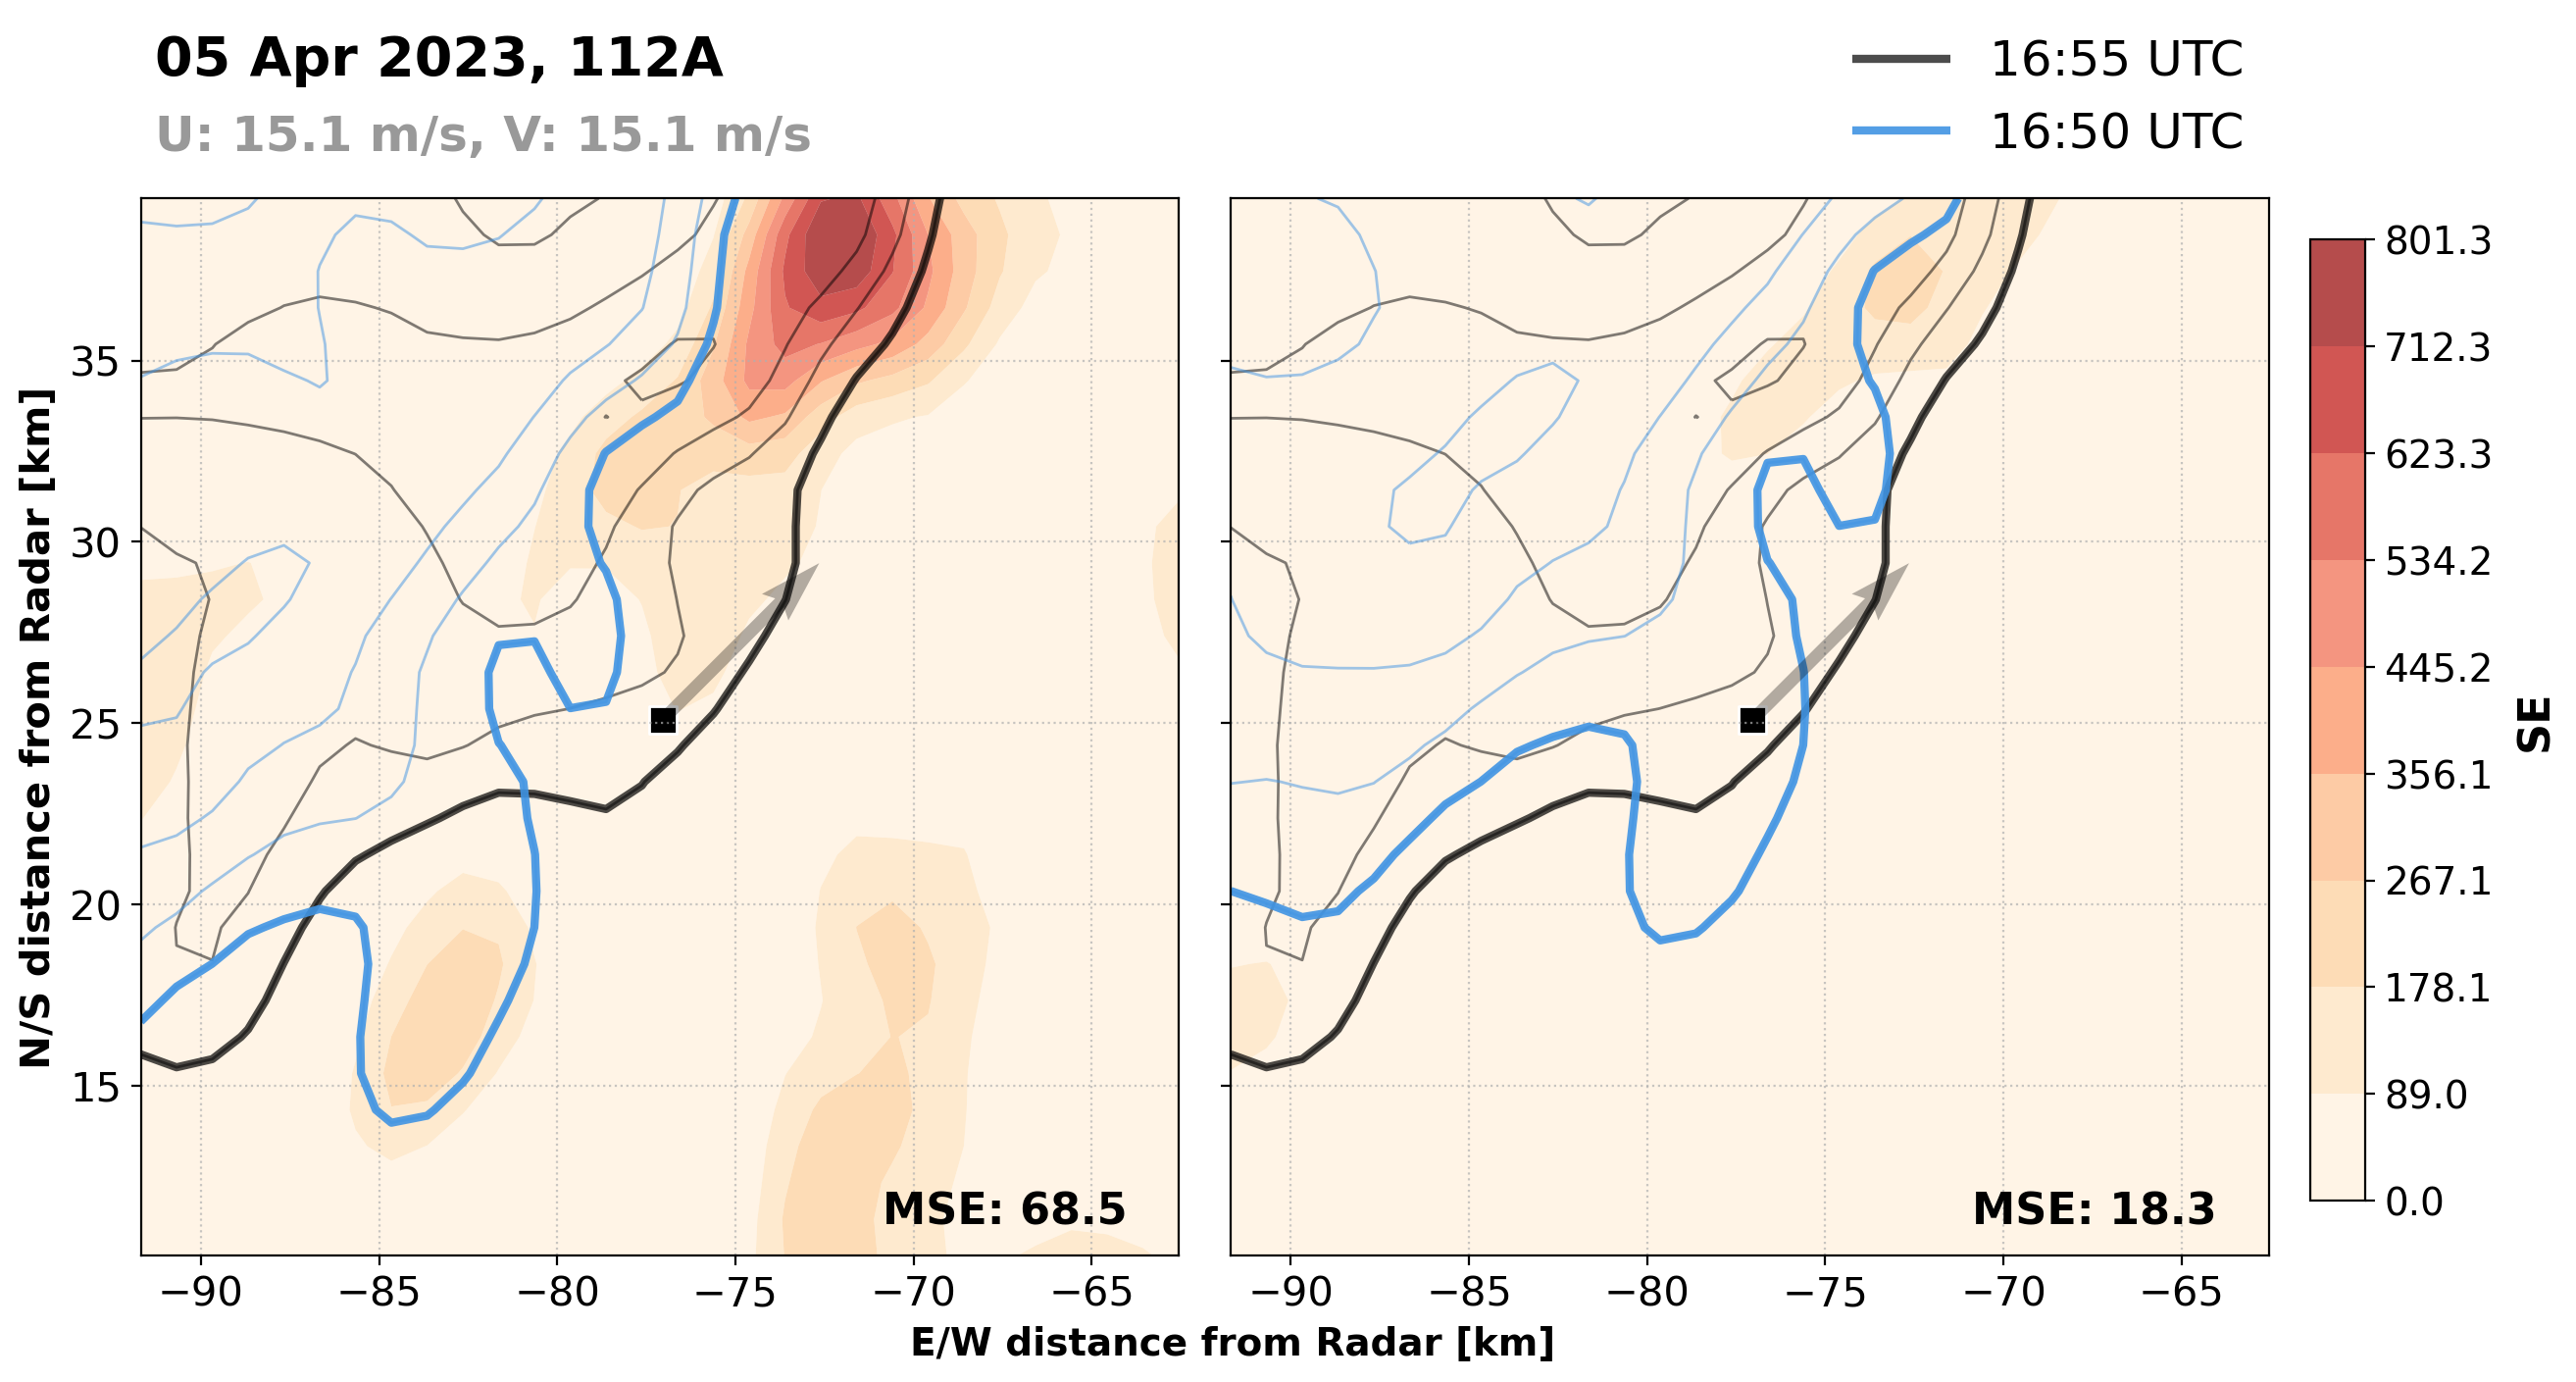

Getting Radar Subset for 215A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (22.784263610839844), gives
U: 18.1 m/s and V: 12.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

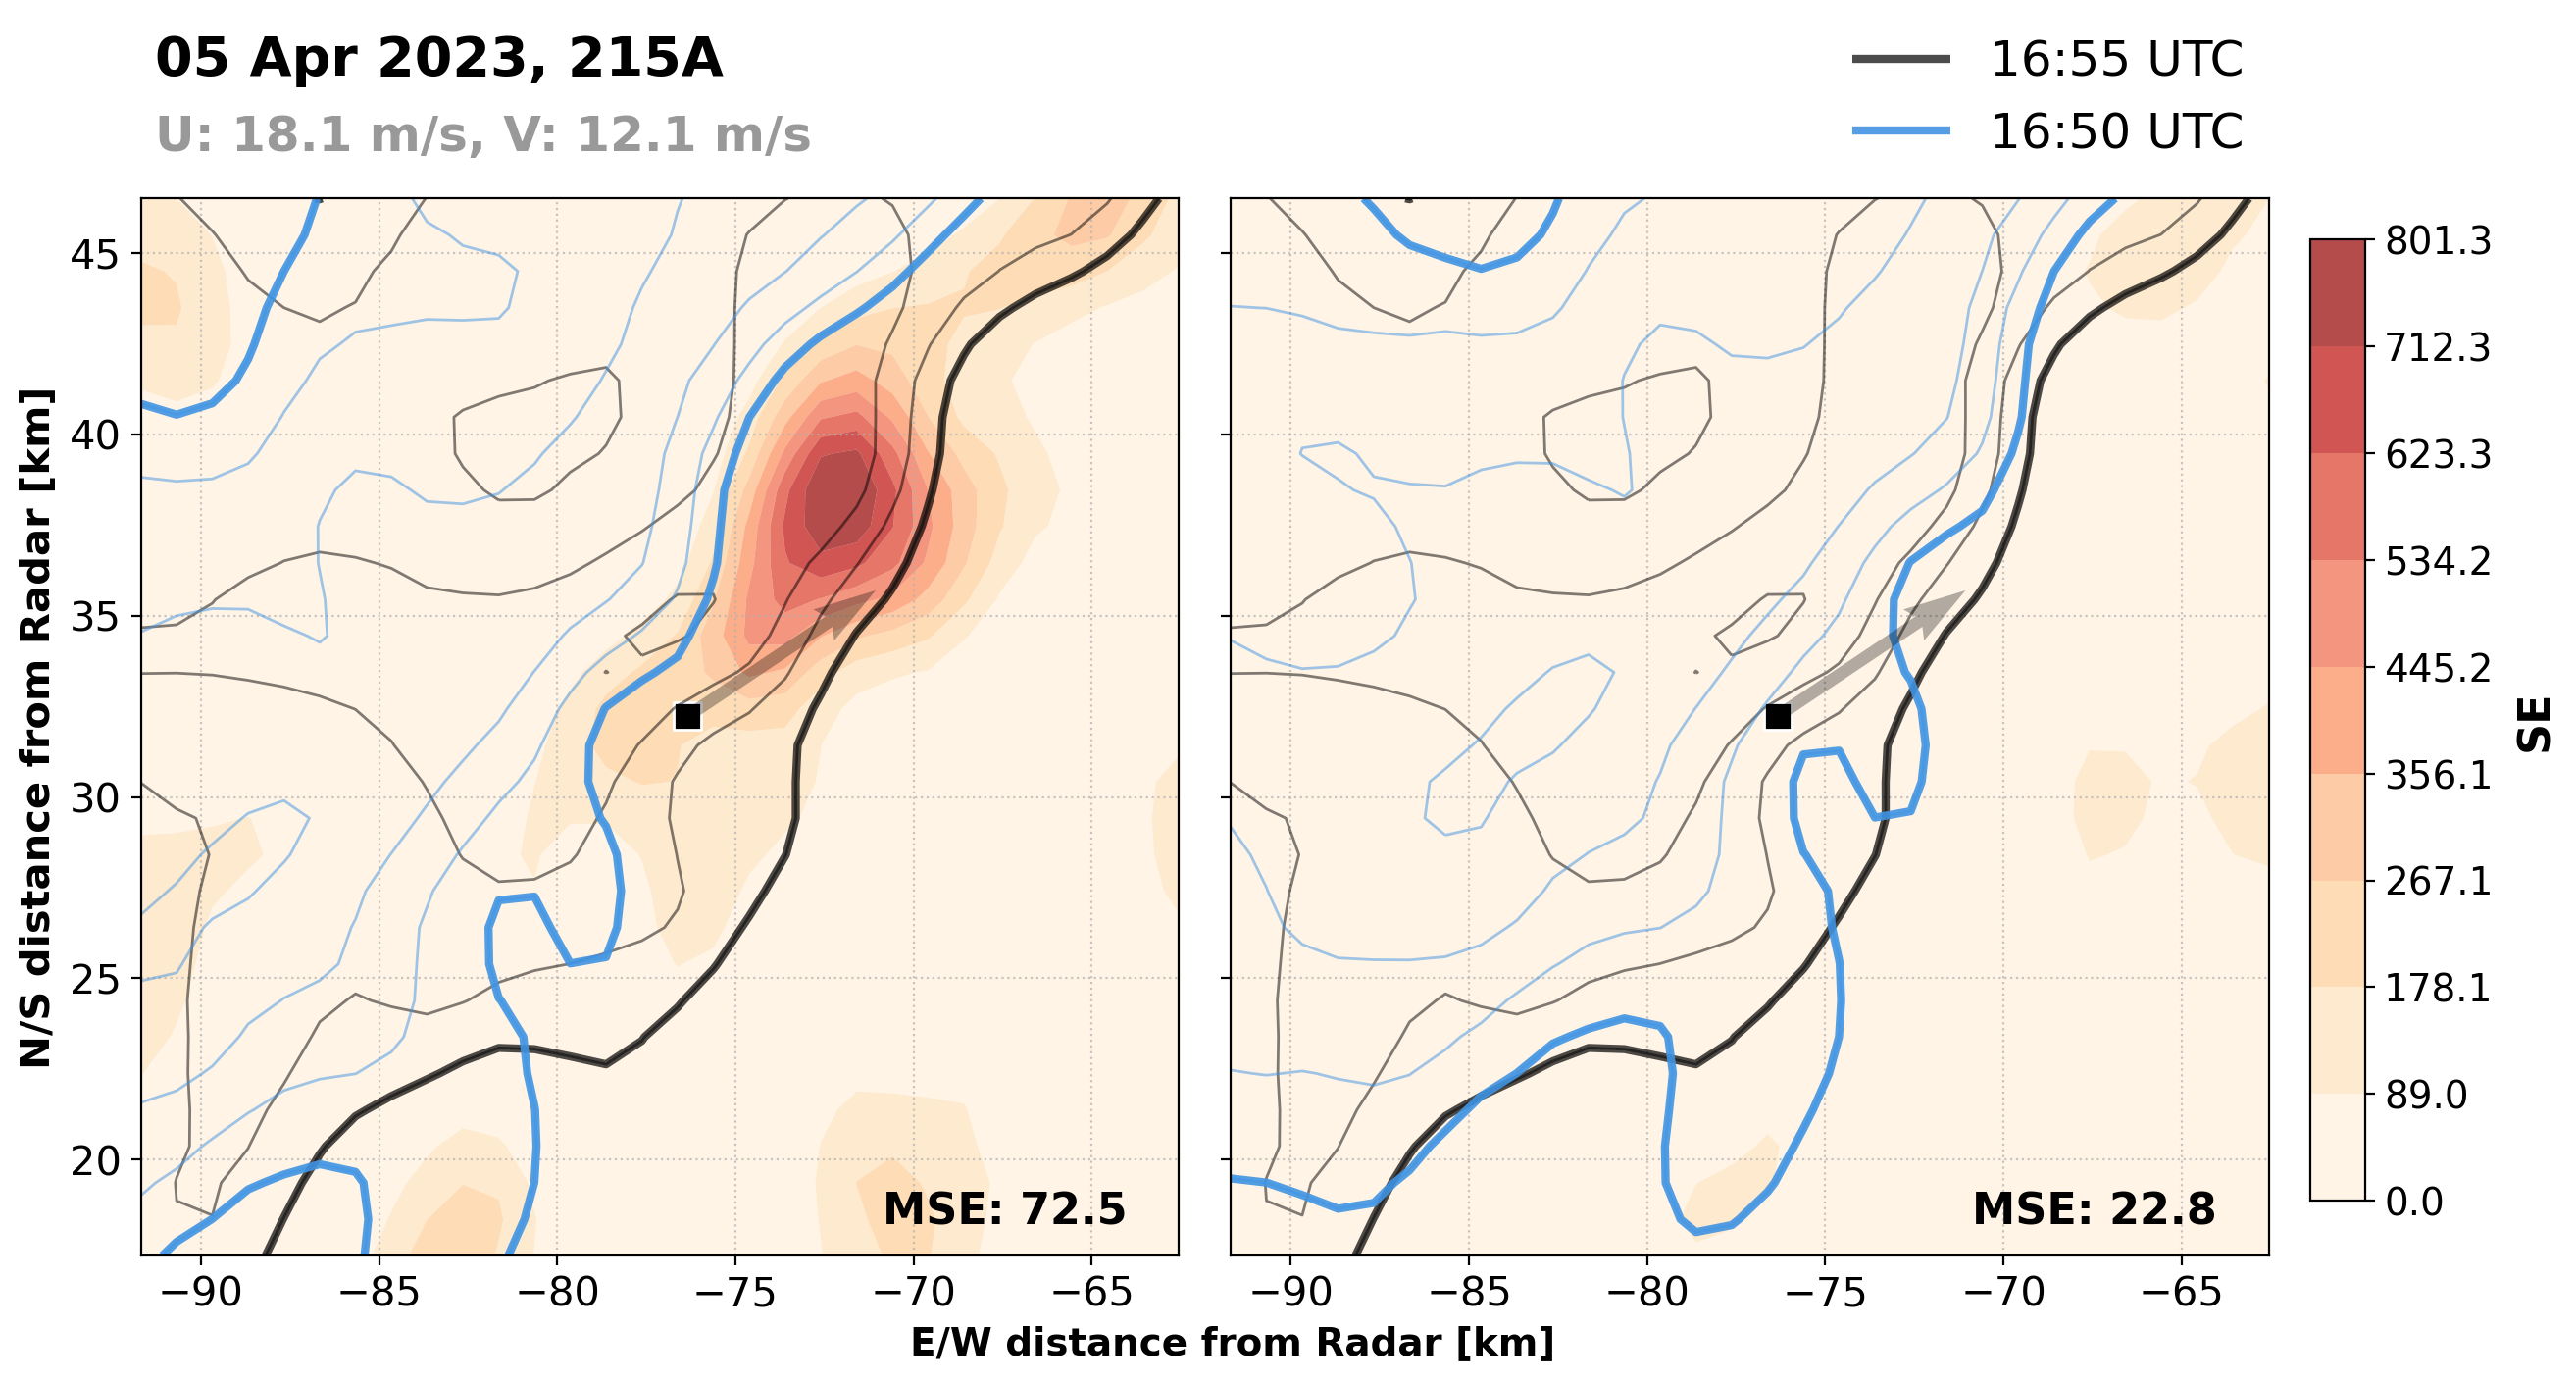

Getting Radar Subset for 218A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (21.88919448852539), gives
U: 18.1 m/s and V: 12.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

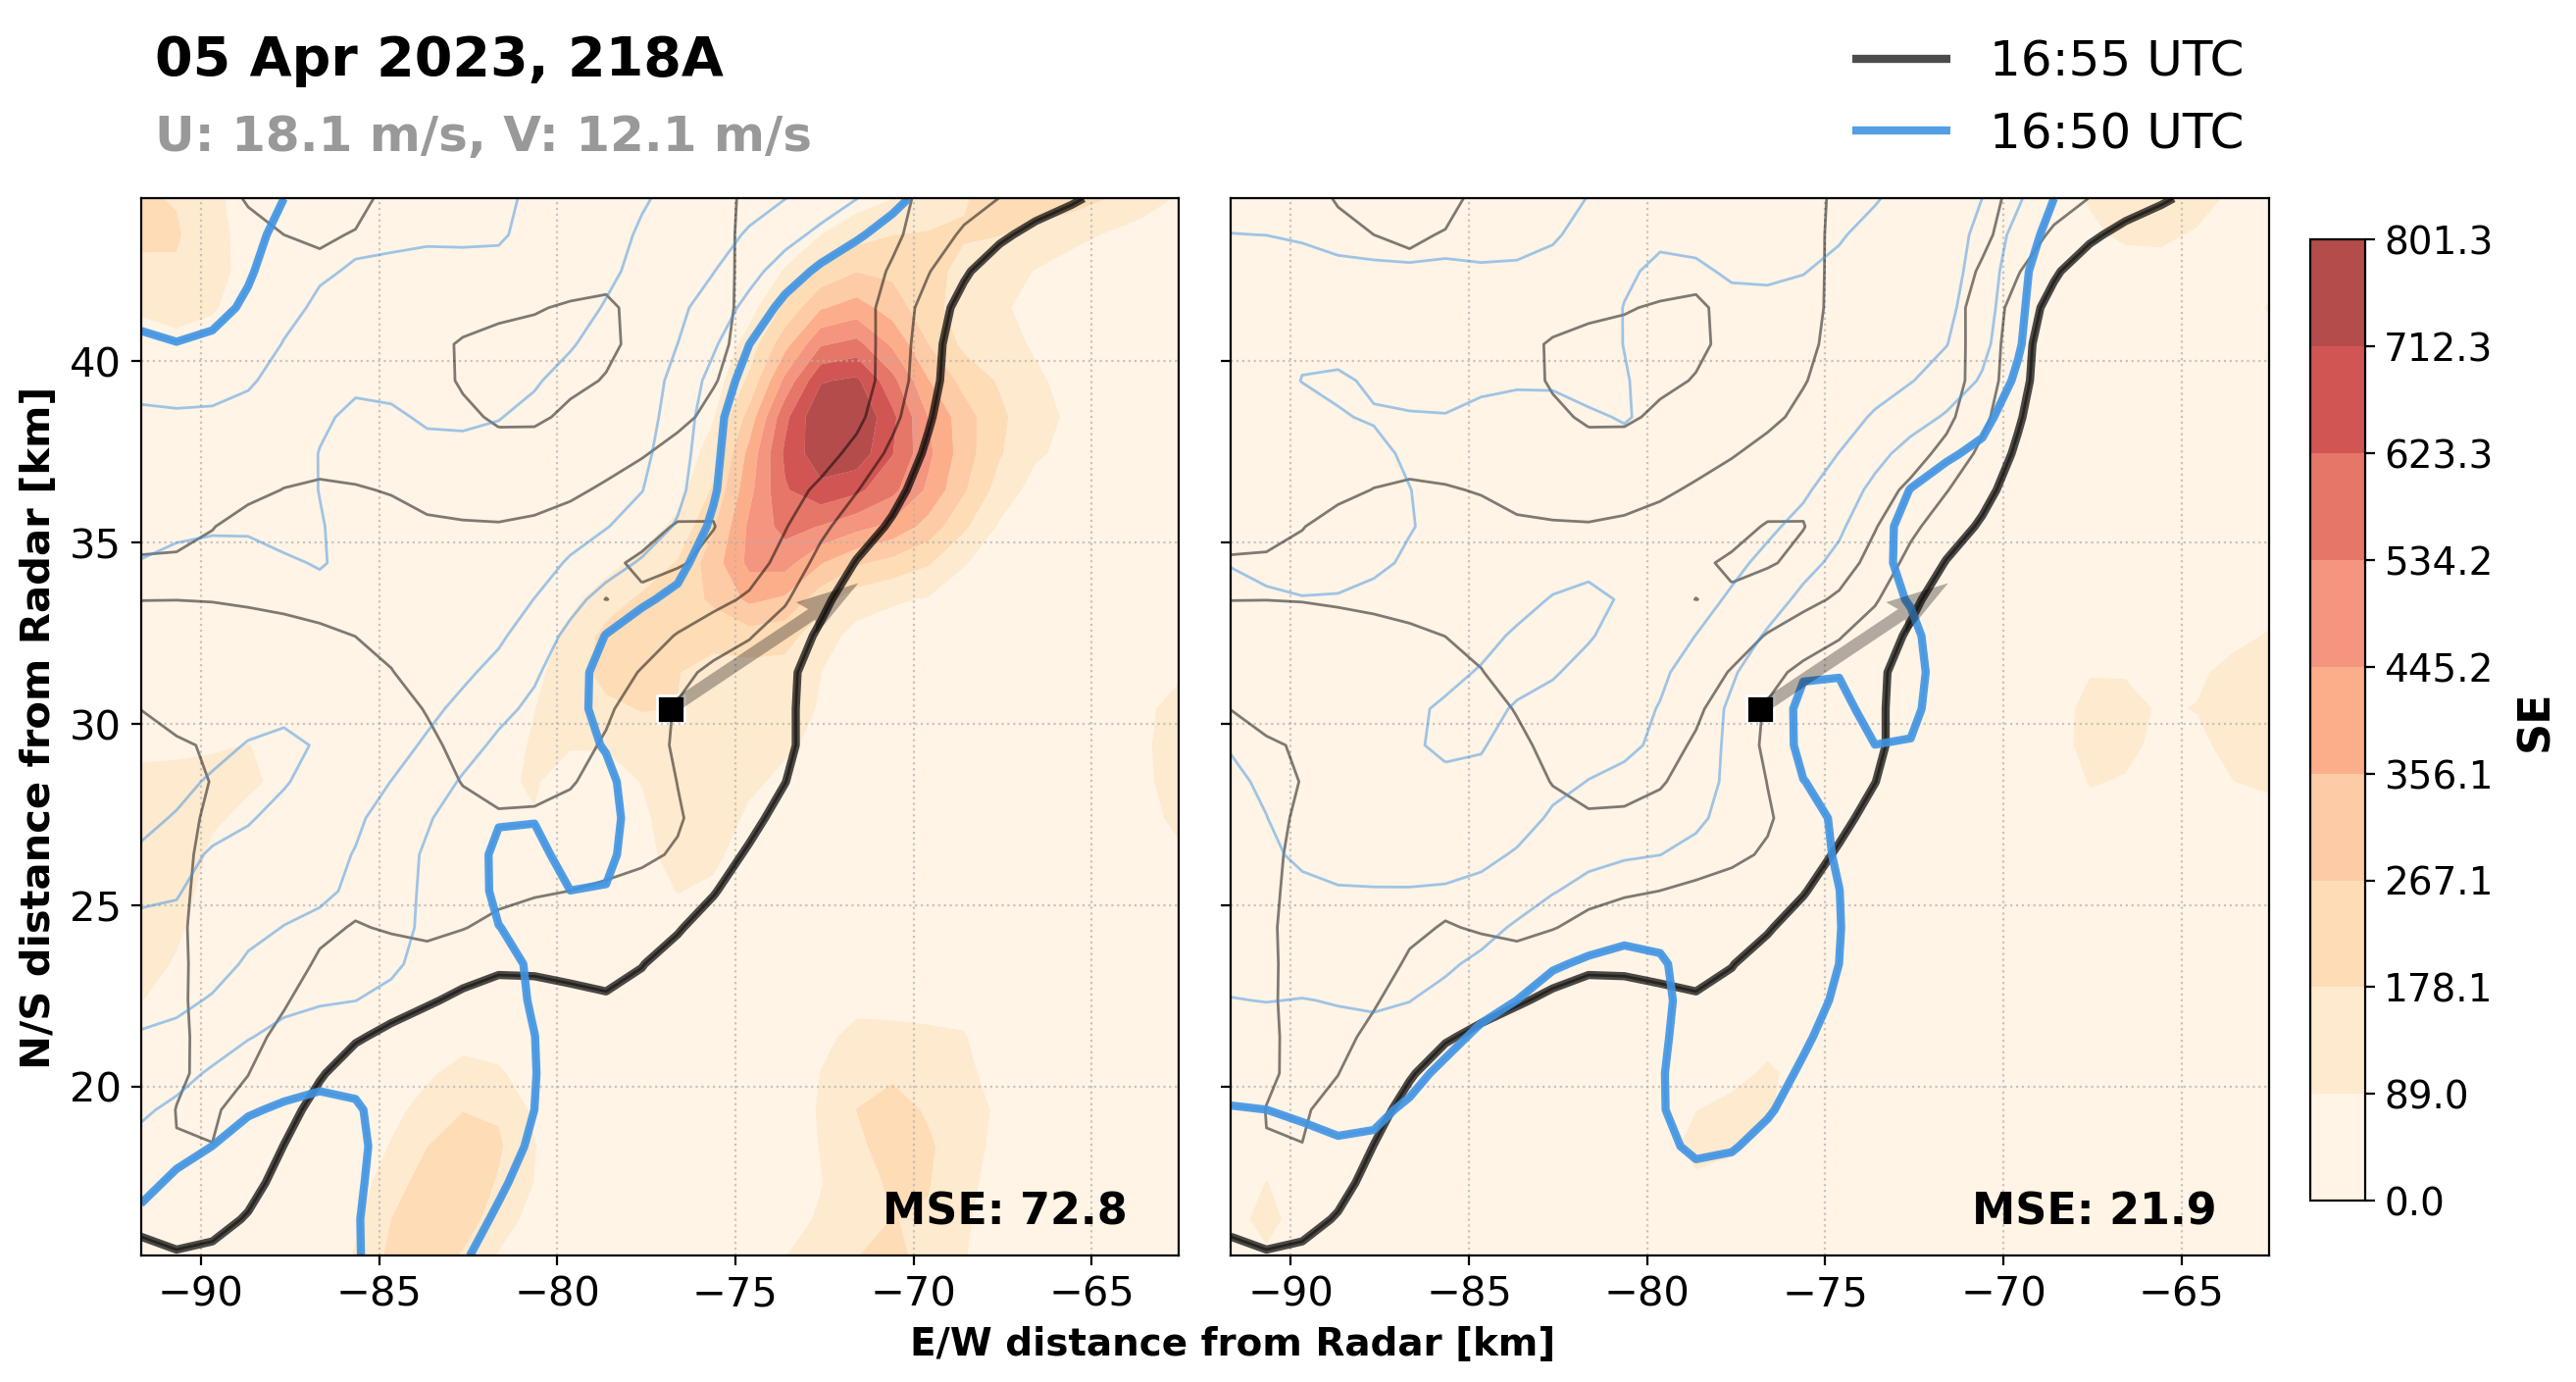

Getting Radar Subset for 220A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (19.970373153686523), gives
U: 15.1 m/s and V: 12.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

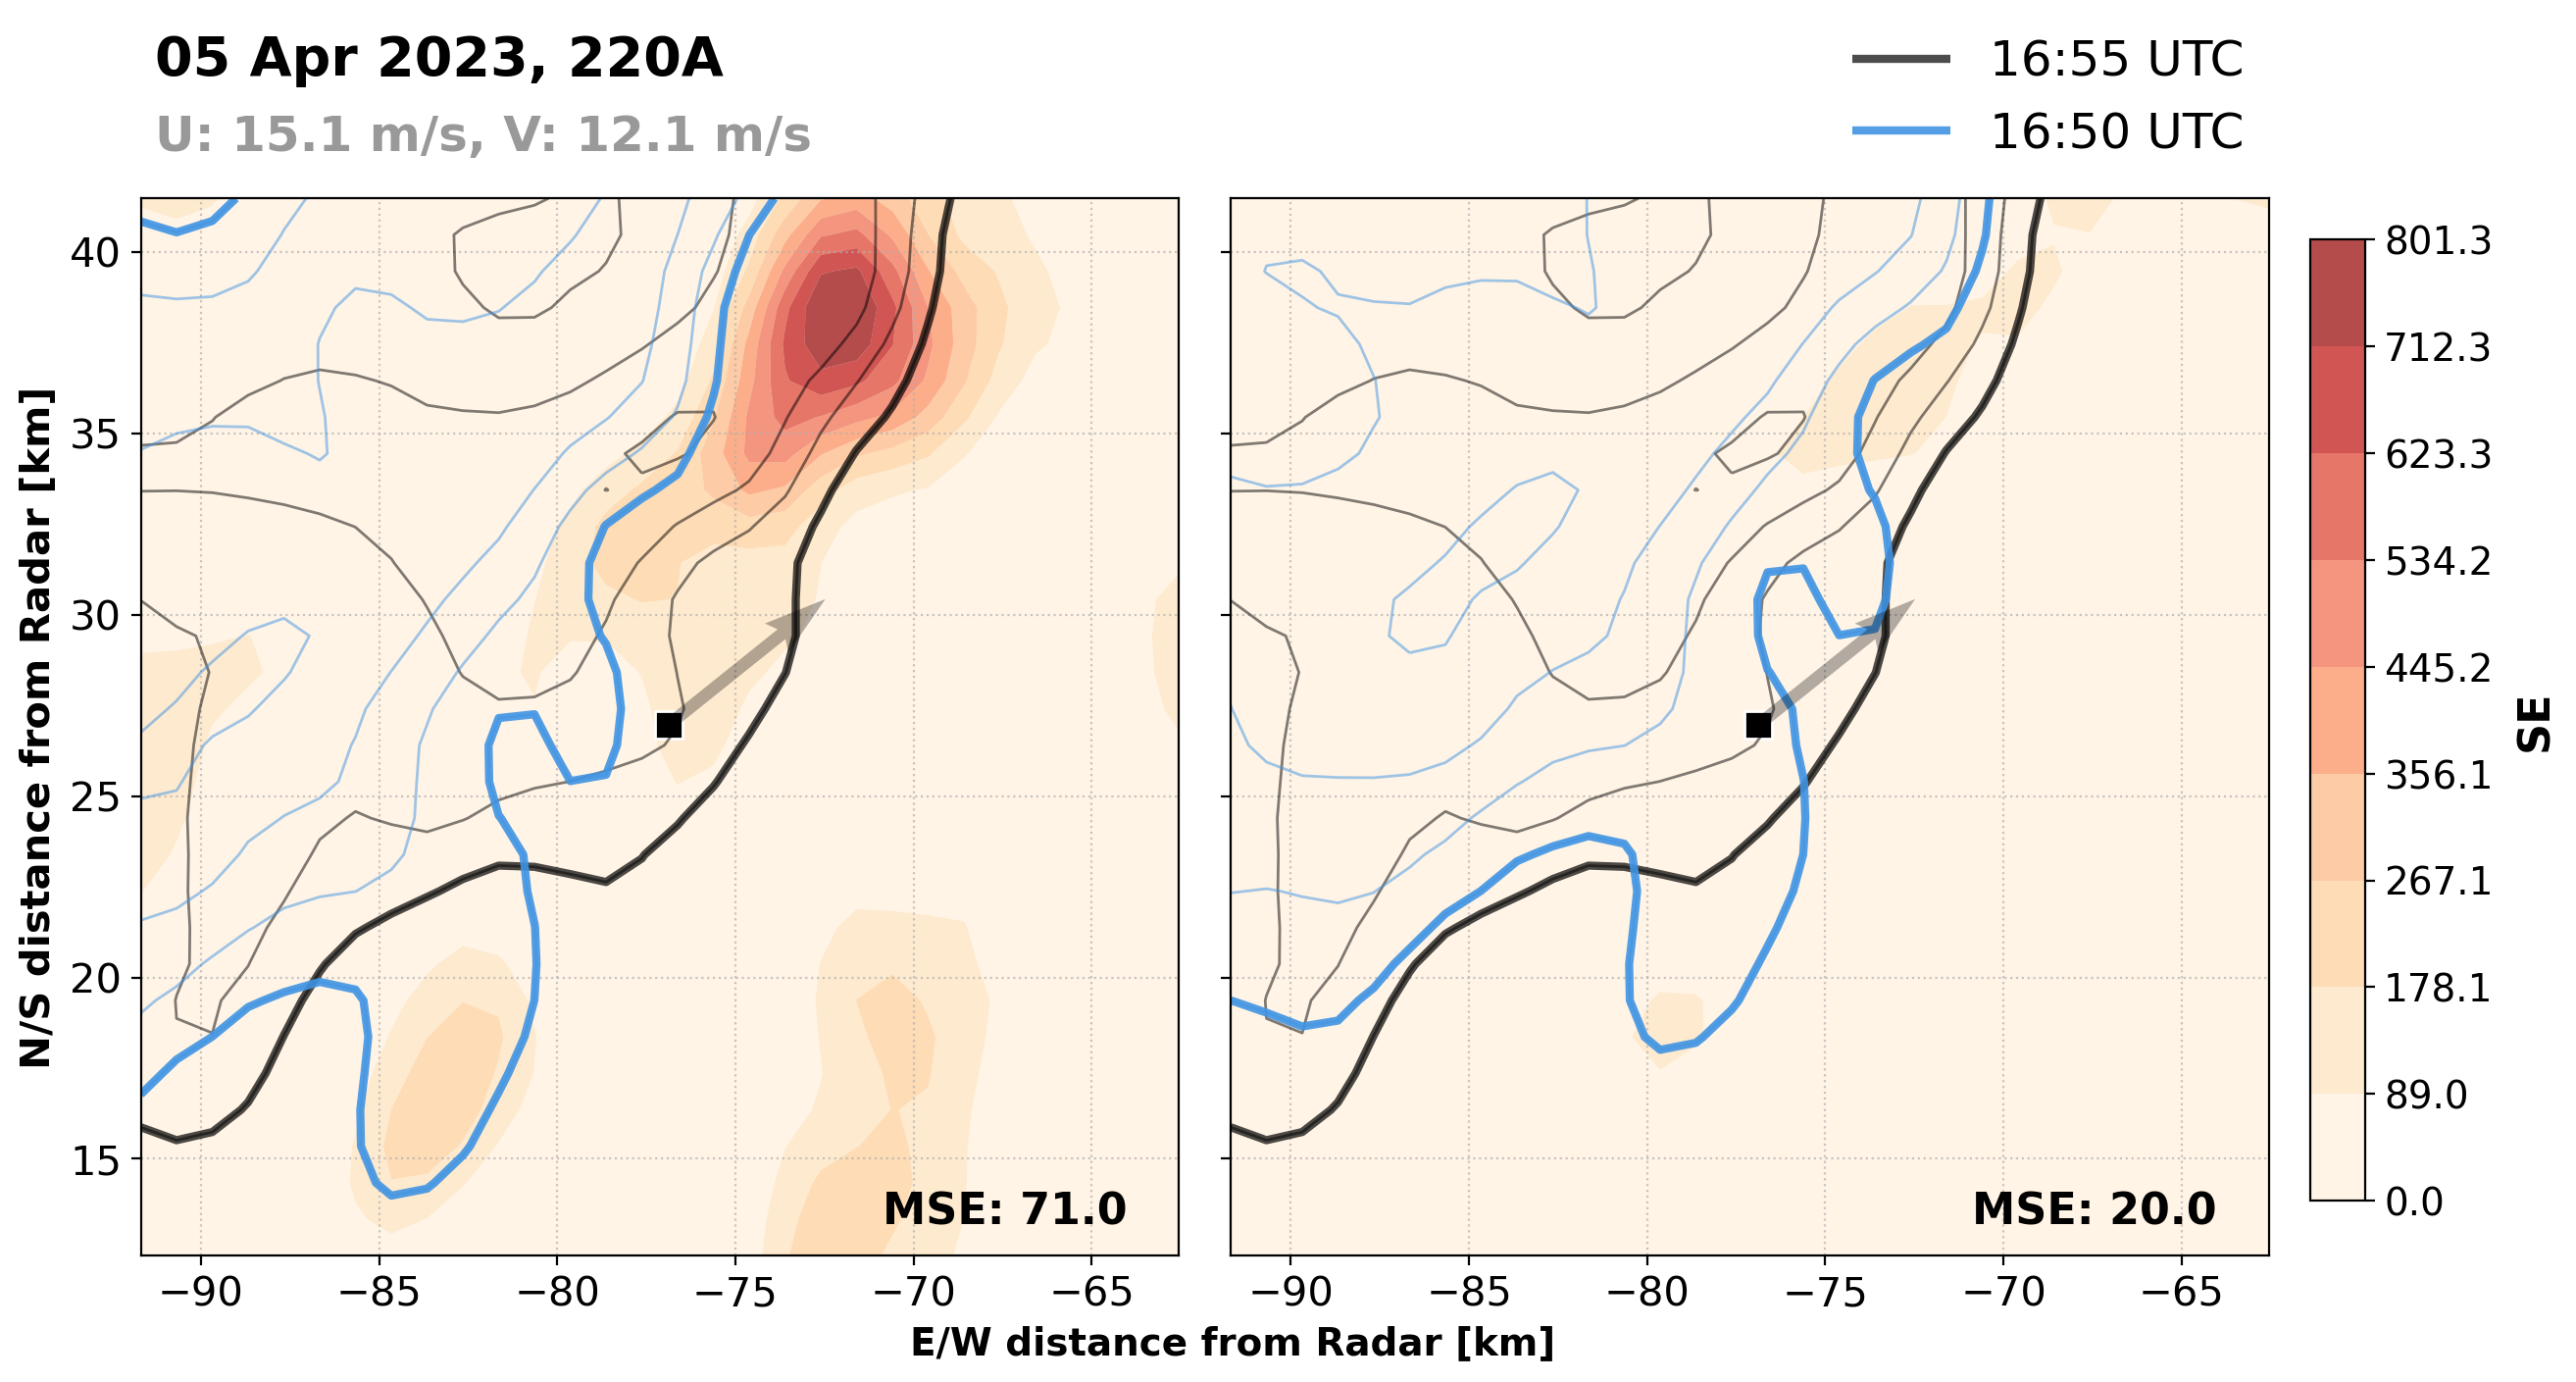

Getting Radar Subset for 224A...
169 171


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pyart\map\gates_to_grid.py:169: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  " to Barnes2 on June 1st.", DeprecationWarning)


minimum MSE (20.829713821411133), gives
U: 18.1 m/s and V: 15.1 m/s


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series._values, index, value)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\frame.py:3033: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine.set_value(series

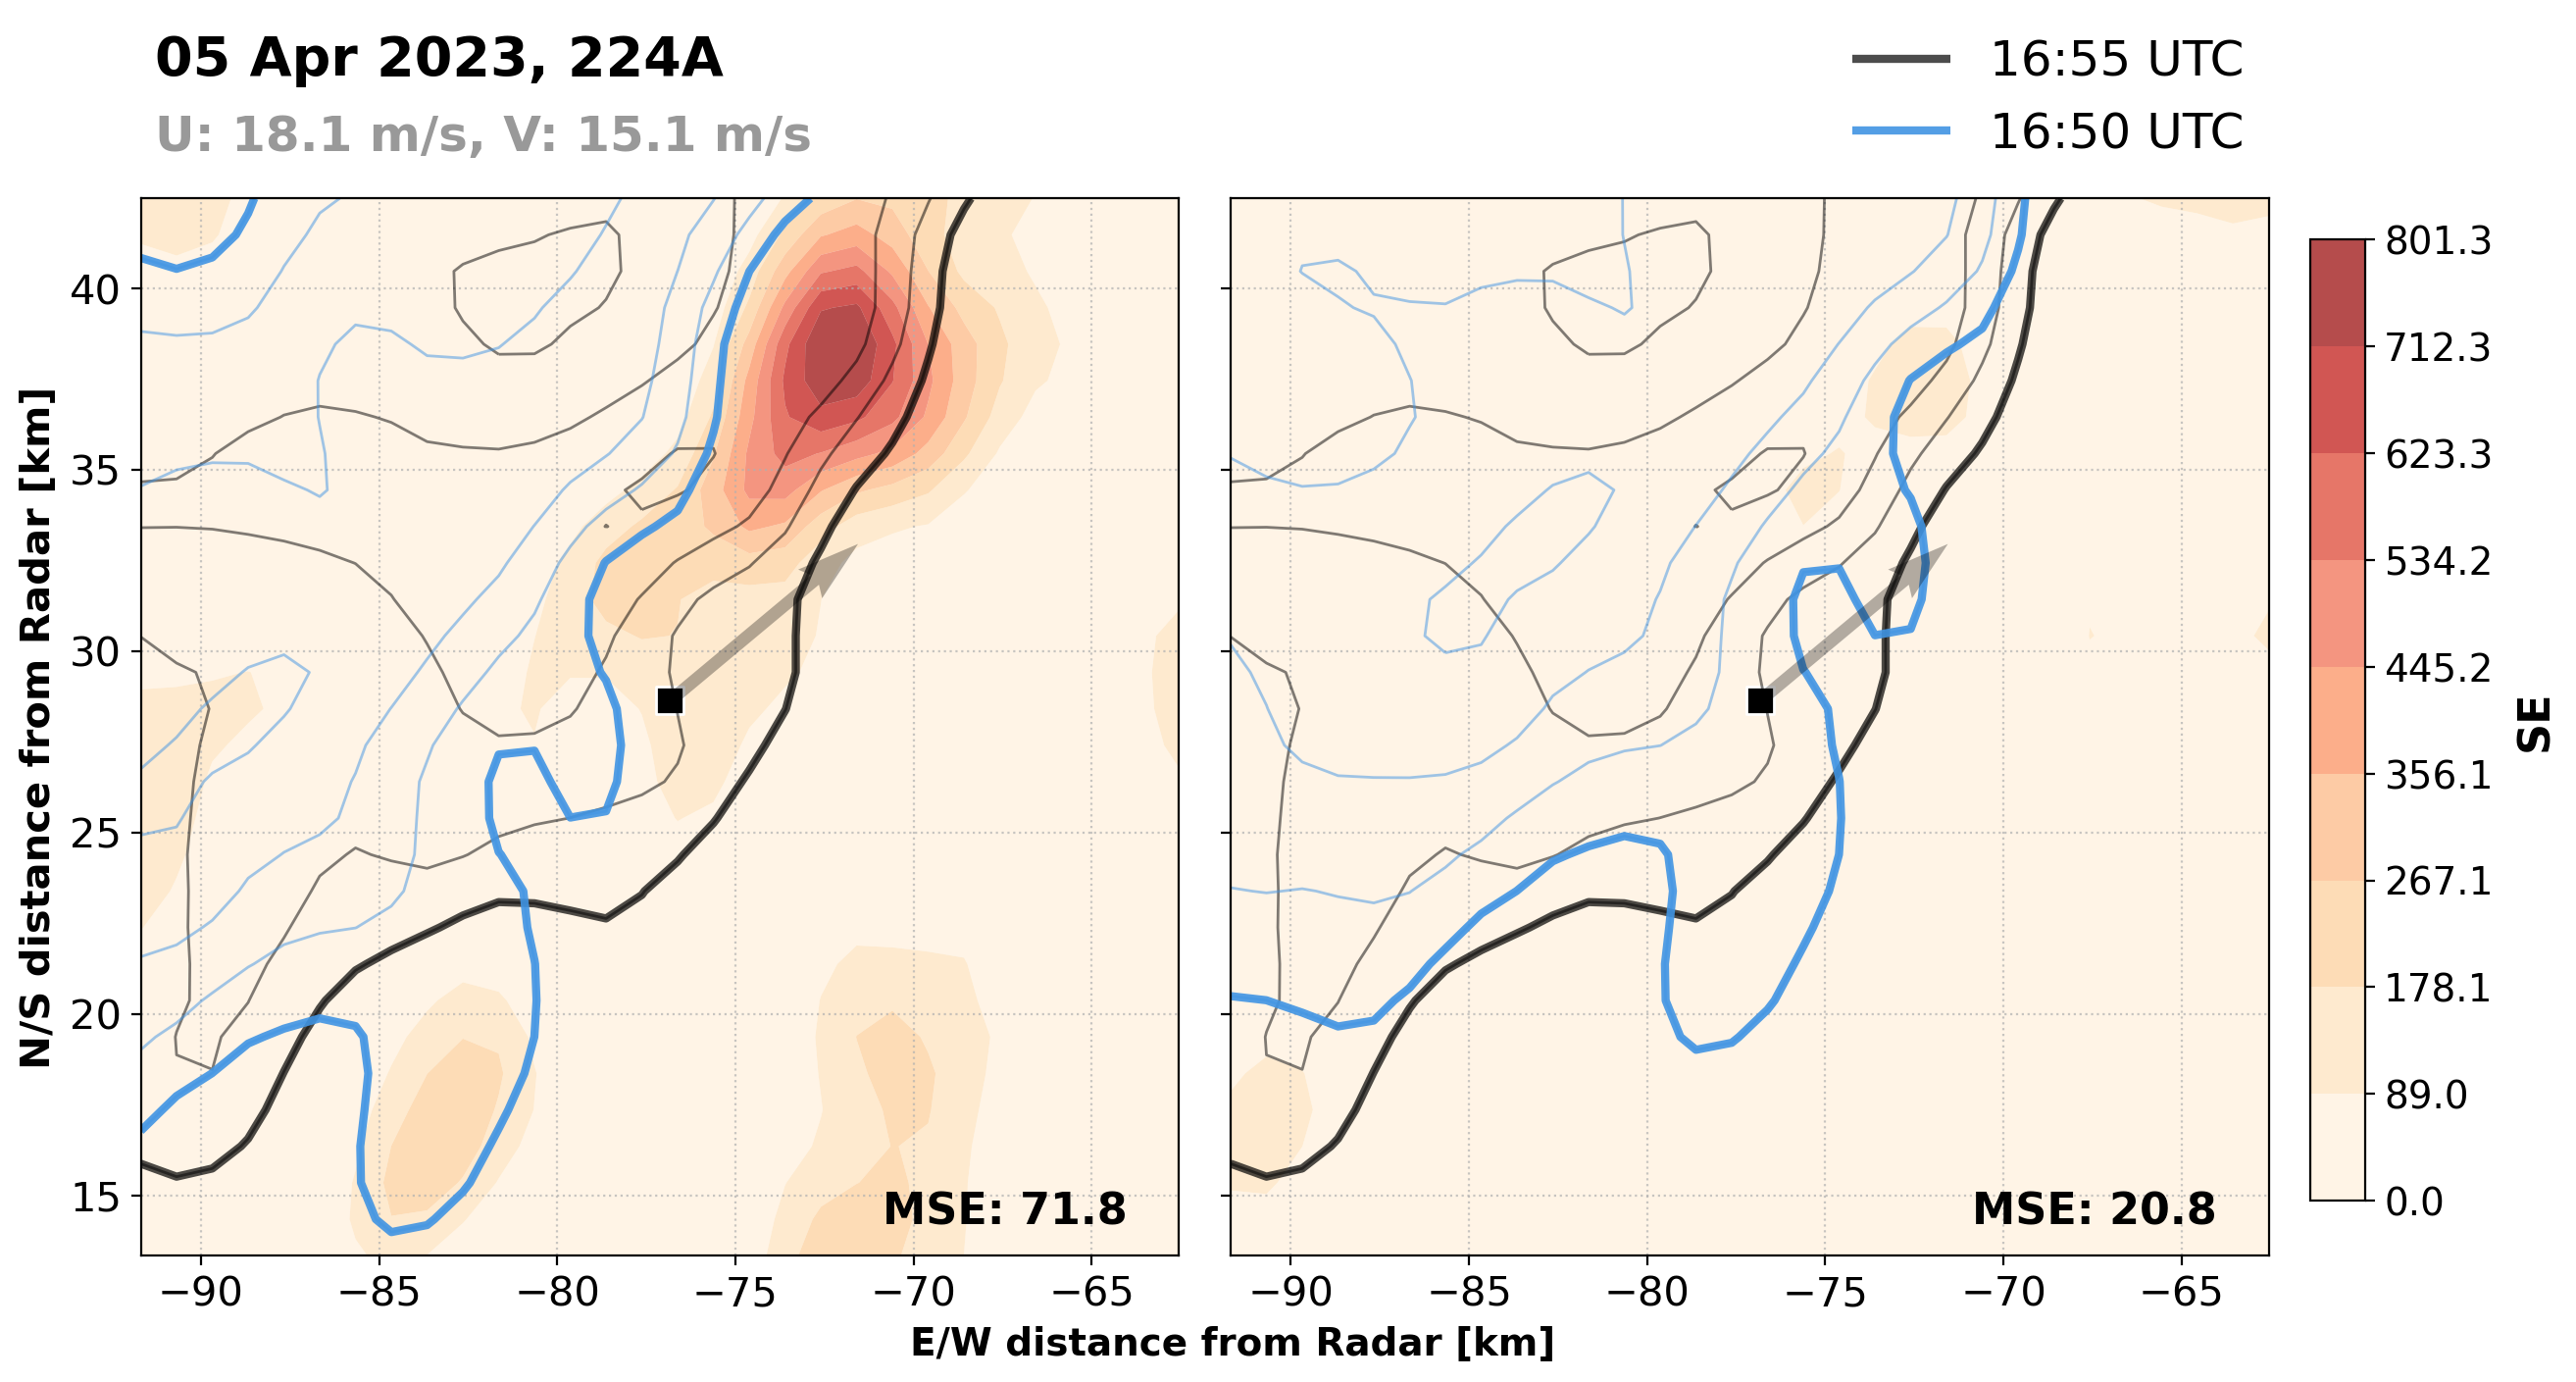

In [29]:
## find storm motion!

#####################################
# USER EDIT - get this out of the CSV and loop!
#
# sticknet information

for i in [2,3,7,8,10,11,14,17,19,23]:
#    if sns.loc[i]['TOA_coldpool_final'] != np.nan:
    # unpack data
    sticknet = sns.loc[i]['ID']
    TOA = pd.to_datetime(TOA50)
    SN_lat = sns.loc[i]['lat']
    SN_lon = sns.loc[i]['lon']

    # nearest Radar site
    station='KNQA'

    #####################################
    print('Getting Radar Subset for '+sticknet+'...')

    # find two different times around TOA
    analysis_time1 = TOA - dt.timedelta(minutes=5)
    analysis_time2 = TOA + dt.timedelta(minutes=5)

    # find location of radar
    radar_lat, radar_lon = get_radar_loc(station)   

    # find the distance between the sticknet and radar
    xsn, ysn = get_dxdy(SN_lat, SN_lon, radar_lat, radar_lon)

    # get radar data 
    radar_namelist1, radar_list1 = get_radar_from_aws(station, analysis_time1, analysis_time2)

    # if you didn't get two files, try getting a later time
    # this could definitely be optimized!!
    if len(radar_list1) < 2: 
        radar1 = radar_list1[0]
        _, radar_list = get_radar_from_aws(station, analysis_time2, analysis_time2+dt.timedelta(minutes=5))
        radar2 = radar_list[0]
    else:  
        radar1 = radar_list1[0]
        radar2 = radar_list1[1]

    # get reflectivity subset around sticknet
    x, y, ref1 = get_radar_subset(radar1, xsn, ysn, station)
    _, _, ref2 = get_radar_subset(radar2, xsn, ysn, station)

    # pull the radar scan times, and find the change in time between the two
    time1 = dt.datetime.strptime(radar1.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')
    time2 = dt.datetime.strptime(radar2.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')
    dtime = (time2-time1).seconds

    # set the box radius
    # this is the box that gets moved around to figure out storm motion 
    # the inital subset box is 60 km (30-km radius), so to get a box of 30 km (15-km radius), 
    # subtract desired radius (20) from 30
    box_radius = 30-15 
    # make sure that box radius isn't too large, otherwise you'll run out of data in the initial 60 km box


    # find the storm motion!
    # xbest is the xshift, ybest is the yshift, and U and V is the storm motion
    xbest, ybest, U, V = min_mse_solidgrid(ref1, ref2, dtime, boxr=box_radius)

    sns.at[i,'U']=U
    sns.at[i,'V']=V

    # plot it!

    ## plot >30 dbz countours to make sure the result makes sense 

    fig, axes = plt.subplots(1, 2, figsize=(14,7), sharey=True)

    ############################################
    ### Plot from BEFORE grid shift 

    # get x and y grids
    xx, yy = np.meshgrid(x[box_radius:-box_radius]/1000, y[box_radius:-box_radius]/1000)

    # subset MSE and reflectivity before shift 
    mse_start = ((ref1[box_radius:-box_radius, box_radius:-box_radius]-
                  ref2[box_radius:-box_radius, box_radius:-box_radius])**2)
    r1 = ref1[box_radius:-box_radius, box_radius:-box_radius]
    r2 = ref2[box_radius:-box_radius, box_radius:-box_radius]

    # get plot levels for colormap
    levels = np.linspace(0, mse_start.max(), 10)

    # plot 
    axes[0].contourf(xx, yy, mse_start, cmap='OrRd', levels=levels, alpha=0.7, antialiased=True)
    # thin - every 5 dbz
    axes[0].contour(xx, yy, r2, colors='k',       levels = np.arange(35,70,5), alpha=0.5, linewidths=1)
    axes[0].contour(xx, yy, r1, colors='#4094e3', levels = np.arange(35,70,5), alpha=0.5, linewidths=1)
    # thick - 30 dbz line 
    axes[0].contour(xx, yy, r2, colors='k',       levels = [35, 90], alpha=0.7, linewidths=3)
    axes[0].contour(xx, yy, r1, colors='#4094e3', levels = [35, 90], alpha=0.9, linewidths=3)


    ############################################
    ### Plot from AFTER grid shift 

    # subset reflectivity after shift, and calculated mse
    new_r2 = ref2[box_radius:-box_radius, box_radius:-box_radius]

    # different subset needed based on direction of y shift 
    if V < 0:
        new_r1 = ref1[(box_radius+abs(ybest)):(-box_radius+abs(ybest)), (box_radius-xbest):(-box_radius-xbest)]
        xx2, yy2 = xx,yy
    else:
        new_r1 = ref1[(box_radius-ybest):(-box_radius-ybest), (box_radius-xbest):(-box_radius-xbest)]
        xx2, yy2 = xx,yy

    mse_end = ((new_r1-new_r2)**2)

    # plot
    im=axes[1].contourf(xx2, yy2, mse_end, cmap='OrRd', levels=levels, alpha=0.7, antialiased=True)
    # thin - every 5 dbz
    axes[1].contour(xx2, yy2, new_r2, colors='k',       levels = np.arange(35,70,5), alpha=0.5, linewidths=1)
    axes[1].contour(xx2, yy2, new_r1, colors='#4094e3', levels = np.arange(35,70,5), alpha=0.5, linewidths=1)
    # thick - 35 dbz line 
    CS1 = axes[1].contour(xx2, yy2, new_r2, colors='k',       levels = [35, 90], alpha=0.7, linewidths=3)
    CS2 = axes[1].contour(xx2, yy2, new_r1, colors='#4094e3', levels = [35, 90], alpha=0.9, linewidths=3)


    ############################################

    # plot details
    plt.subplots_adjust(wspace=0.05)

    # add labels 
    axes[0].set_ylabel('N/S distance from Radar [km]', weight='bold')
    plt.text(0.405, 0.038, 'E/W distance from Radar [km]', fontsize=14, weight='bold', transform = fig.transFigure)

    # add grid and sticknet location
    for ax in axes:
        ax.grid(ls=':', alpha=0.7)
        ax.scatter(xsn/1000, ysn/1000, marker='s', color='k', edgecolor='w', linewidth=1, s=100)
        ax.quiver(xsn/1000, ysn/1000, U, V, scale=100, zorder=10, alpha=0.3, width=0.012)

    # add colorbar 
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.915, 0.15, 0.02, 0.7])
    cbar=fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('SE', fontsize = 16, labelpad = 8, weight='bold')
    cbar.ax.tick_params(labelsize = 14)

    # MSE text
    axes[0].text(.95, .03, f'MSE: {mse_start.mean():.1f}',fontsize=16,weight='bold',ha='right',transform=axes[0].transAxes)
    axes[1].text(.95, .03, f'MSE: {mse_end.mean():.1f}',  fontsize=16,weight='bold',ha='right',transform=axes[1].transAxes)

    # add left side of Title
    date = time1.strftime('%d %b %Y')
    plt.suptitle(f'{date}, {sticknet}', fontsize=20, y=1., x=0.13, ha='left', weight='bold') ;
    plt.text(0.13, 0.915, f'U: {U} m/s, V: {V} m/s', fontsize = 18, transform=fig.transFigure, color='0.6', weight='bold')

    # add right side of Title
    CS1.collections[0].set_label(time2.strftime('%H:%M UTC'))
    CS2.collections[0].set_label(time1.strftime('%H:%M UTC'))
    axes[1].legend(fontsize=18, loc=(.58,1.02), ncol=1, frameon=False)
    plt.show()
#     fig.savefig('E:\\PERiLS_Y2\\methods\\Storm_motion\\IOP4\\'+sticknet+'.png', format='png',bbox_inches='tight')
#     plt.close()
#     print('Finished Plotting to Folder and Adding Data in Excel Doc for '+sticknet)
# else:
#     sns.at[i,'U']=np.nan
#     sns.at[i,'V']=np.nan